# 11. Thuật toán Tối ưu
Chúng tôi tin rằng khi đã theo dõi đến chương này của cuốn sách, hẳn là bạn đã kinh qua nhiều dạng thuật toán tối ưu tiên tiến để huấn luyện các mô hình học sâu. Chúng là công cụ cho phép ta liên tục cập nhật các tham số của mô hình và cực tiểu hóa giá trị hàm mất mát khi đánh giá trên tập huấn luyện. Sự thật là có nhiều người hài lòng với việc xem những thuật toán tối ưu như một hộp đen ma thuật (với các câu thần chú như “**Adam**”, “**NAG**”, hoặc “**SGD**”) có tác dụng cực tiểu hóa hàm mục tiêu.

Tuy nhiên, để làm tốt thì ta cần những kiến thức chuyên sâu hơn. Những giải thuật tối ưu đóng vai trò quan trọng trong học sâu. Một mặt, việc huấn luyện một mô hình học sâu phức tạp có thể mất hàng giờ, hàng ngày, thậm chí là hàng tuần. Chất lượng của thuật toán tối ưu ảnh hưởng trực tiếp đến độ hiệu quả của quá trình huấn luyện của mô hình. Mặt khác, việc hiểu rõ nguyên lý của các thuật toán tối ưu khác nhau cùng vai trò của các tham số đi kèm sẽ giúp ta điều chỉnh các siêu tham số một cách có chủ đích nhằm cải thiện hiệu suất của các mô hình học sâu.

Trong chương này, chúng tôi sẽ mô tả sâu hơn các thuật toán tối ưu thông dụng trong học sâu. Hầu hết tất cả các bài toán tối ưu xuất hiện trong học sâu đều là *không lồi* (**nonconvex**). Tuy nhiên, kiến thức từ việc thiết kế và phân tích các thuật toán giải quyết bài toán tối ưu lồi vẫn rất hữu ích. Do vậy, phần này sẽ tập trung vào giới thiệu tối ưu lồi và chứng minh một thuật toán *hạ gradient ngẫu nhiên* (**stochastic gradient descent**) đơn giản áp dụng cho hàm mục tiêu lồi.

## 11.1. Tối ưu và Học sâu
Trong phần này, ta sẽ thảo luận mối quan hệ giữa tối ưu và học sâu, cũng như những thách thức khi áp dụng các thuật toán tối ưu trong học sâu. Đối với một bài toán học sâu, đầu tiên chúng ta thường định nghĩa hàm mất mát, sau đó sử dụng một thuật toán tối ưu nhằm cực tiểu hóa hàm mất mát đó. Hàm mất mát trong học sâu thường được xem là hàm mục tiêu của bài toán tối ưu. Thông thường, đa số các thuật toán tối ưu thường giải quyết bài toán *cực tiểu hóa*. Tuy nhiên, nếu ta cần *cực đại hóa*, có một cách khá đơn giản là đổi dấu hàm mục tiêu.

### 11.1.1. Tối ưu và Ước lượng
Mặc dù các phương pháp tối ưu thường được sử dụng để cực tiểu hóa hàm mất mát trong học sâu, nhưng mục đích của tối ưu và học sâu về bản chất là khác nhau. Mối quan tâm của tối ưu chủ yếu là cực tiểu hóa một mục tiêu nào đó, trong khi đối với học sâu là tìm kiếm một mô hình phù hợp với một lượng dữ liệu hữu hạn. Trong Section 4.4, ta đã thảo luận chi tiết về sự khác biệt giữa các mục đích trên. Chẳng hạn như là sự khác biệt giữa lỗi huấn luyện và lỗi khái quát. Do hàm mục tiêu của thuật toán tối ưu thường là hàm mất mát trên tập huấn luyện nên mục đích của tối ưu là giảm thiểu lỗi huấn luyện. Tuy nhiên, mục đích của *suy luận thống kê* (**statistical inference**) và học sâu nói riêng là giảm thiểu lỗi khái quát. Để thực hiện điều này, bên cạnh việc giảm thiểu lỗi huấn luyện, ta cần chú ý đến hiện tượng quá khớp. Hãy bắt đầu bằng việc nhập một số thư viện sử dụng trong chương này.

In [1]:
%matplotlib inline
from d2l import torch as d2l
import numpy as np
from mpl_toolkits import mplot3d
import torch

Tiếp theo, ta định nghĩa hai hàm: hàm kỳ vọng  $f$  và hàm thực nghiệm  $g$  để minh họa vấn đề này. Ở đây,  $g$  kém mượt hơn  $f$  vì ta chỉ có một lượng dữ liệu hữu hạn.

In [2]:
def f(x): return x * torch.cos(np.pi * x)
def g(x): return f(x) + 0.2 * torch.cos(5 * np.pi * x)

Đồ thị phía dưới mô tả chi tiết hơn về vấn đề trên. Do ta chỉ có một lượng dữ liệu hữu hạn, cực tiểu của lỗi huấn luyện có thể khác so với cực tiểu kỳ vọng của lỗi (lỗi trên tập kiểm tra).

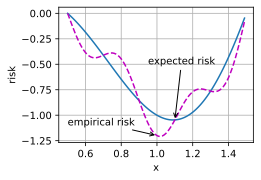

In [3]:
def annotate(text, xy, xytext):  #@save
    d2l.plt.gca().annotate(text, xy=xy, xytext=xytext,
                           arrowprops=dict(arrowstyle='->'))

x = torch.arange(0.5, 1.5, 0.01)
d2l.set_figsize((4.5, 2.5))
d2l.plot(x, [f(x), g(x)], 'x', 'risk')
annotate('empirical risk', (1.0, -1.2), (0.5, -1.1))
annotate('expected risk', (1.1, -1.05), (0.95, -0.5))

## 11.2. Các Thách thức của Tối ưu trong Học sâu
Ở chương này, ta sẽ chỉ tập trung vào chất lượng của thuật toán tối ưu trong việc cực tiểu hóa hàm mục tiêu, thay vì lỗi khái quát của mô hình. Trong Section 3.1, ta đã phân biệt giữa nghiệm theo công thức và nghiệm xấp xỉ trong các bài toán tối ưu. Trong học sâu, đa số các hàm mục tiêu khá phức tạp và *không tính được nghiệm theo công thức*. Thay vào đó, ta phải dùng các *thuật toán tối ưu xấp xỉ*. Các thuật toán tối ưu dưới đây được liệt vào loại này.

Có rất nhiều thách thức về tối ưu trong học sâu. *Các điểm cực tiểu*, *điểm yên ngựa*, *tiêu biến gradient* là một số vấn đề gây đau đầu hơn cả. Hãy cùng tìm hiểu về các vấn đề này.

## 11.3. Các vùng Cực tiểu
Cho hàm mục tiêu  $f(x)$ , nếu giá trị của  $f(x)$  tại  $x$  nhỏ hơn các giá trị khác của  $f(x)$  tại lân cận của  $x$  thì  $f(x)$  có thể là *một cực tiểu* (**local minimum**). Nếu giá trị của hàm mục tiêu  $f(x)$  tại  $x$  là nhỏ nhất trên toàn tập xác định thì  $f(x)$  là *giá trị nhỏ nhất* (**global minimum**).

Ví dụ, cho hàm

<center>$f(x) = x \cdot \text{cos}(\pi x) \text{ for } -1.0 \leq x \leq 2.0,$</center>
 
ta có thể tính xấp xỉ cực tiểu và giá trị nhỏ nhất của hàm này.

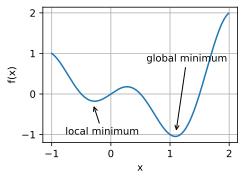

In [4]:
x = torch.arange(-1.0, 2.0, 0.01)
d2l.plot(x, [f(x), ], 'x', 'f(x)')
annotate('local minimum', (-0.3, -0.25), (-0.77, -1.0))
annotate('global minimum', (1.1, -0.95), (0.6, 0.8))

Hàm mục tiêu trong các mô hình học sâu thường có nhiều vùng cực trị. Khi nghiệm xấp xỉ của một bài toán tối ưu đang ở gần giá trị cực tiểu, gradient của hàm mục tiêu tại nghiệm này gần hoặc bằng 0, tuy nhiên nghiệm này có thể chỉ đang cực tiểu hóa hàm mục tiêu một cách cục bộ chứ không phải toàn cục. Chỉ với một *mức độ nhiễu nhất định thì mới có thể đẩy tham số ra khỏi vùng cực tiểu*. Trên thực tế, nhiễu là một trong những tính chất có lợi của hạ gradient ngẫu nhiên khi sự biến động của gradient qua từng minibatch có thể đẩy các tham số ra khỏi các vùng cực tiểu.

## 11.4. Các điểm Yên ngựa
Ngoài các vùng cực tiểu, các *điểm yên ngựa* cũng có gradient bằng 0. Một điểm yên ngựa là bất cứ điểm nào mà tất cả gradient của một hàm bằng 0, nhưng đó không phải là một điểm cực tiểu hay giá trị nhỏ nhất. Xét hàm  $f(x)=x^3$ , đạo hàm bậc một và bậc hai của hàm này bằng 0 tại điểm  $x=0$ . Việc tối ưu có thể bị ngưng trệ tại điểm này, cho dù đó không phải là điểm cực tiểu.

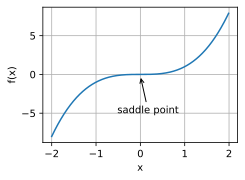

In [5]:
x = torch.arange(-2.0, 2.0, 0.01)
d2l.plot(x, [x**3], 'x', 'f(x)')
annotate('saddle point', (0, -0.2), (-0.52, -5.0))

Các điểm yên ngựa trong không gian nhiều chiều còn khó chịu hơn nhiều, như ví dụ dưới đây. Xét hàm  $f(x,y)=x^2−y^2$ . Hàm này tồn tại một điểm yên ngựa tại  (0,0) . Đây là một điểm cực đại theo  $y$  và là điểm cực tiểu theo  $x$ . Tên gọi của tính chất toán học này bắt nguồn từ chính việc đồ thị tại đó có hình dạng giống một cái yên ngựa.

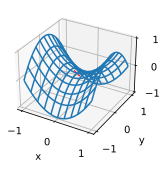

In [6]:
x, y = torch.meshgrid(
    torch.linspace(-1.0, 1.0, 101), torch.linspace(-1.0, 1.0, 101))
z = x**2 - y**2

ax = d2l.plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 10, 'cstride': 10})
ax.plot([0], [0], [0], 'rx')
ticks = [-1, 0, 1]
d2l.plt.xticks(ticks)
d2l.plt.yticks(ticks)
ax.set_zticks(ticks)
d2l.plt.xlabel('x')
d2l.plt.ylabel('y');

Giả sử đầu vào của một hàm là một vector  $k$  chiều và đầu ra là một số vô hướng; do đó **ma trận Hessian** của nó có  $k$  trị riêng (xem thêm tại Section 18.1). Nghiệm của hàm này có thể là một cực tiểu, cực đại, hoặc một điểm yên ngựa tại vị trí mà gradient của hàm bằng 0.

* Điểm cực tiểu là vị trí mà ở đó gradient bằng 0 và các trị riêng của ma trận Hessian đều dương.
* Điểm cực đại là vị trí mà ở đó graident bằng 0 và các trị riêng của ma trận Hessian đều âm.
* Điểm yên ngựa là vị trí mà ở đó gradient bằng 0 và các trị riêng của ma trận Hessian mang cả giá trị âm lẫn dương.

Đối với bài toán trong không gian nhiều chiều, khả năng có một vài trị riêng âm là khá cao. Do đó các điểm yên ngựa có khả năng xuất hiện cao hơn các cực tiểu. Ta sẽ thảo luận một số ngoại lệ của vấn đề này ở phần tới khi giới thiệu đến tính lồi. Nói ngắn gọn, các hàm lồi là hàm có các trị riêng của ma trận Hessian không bao giờ âm. Nhưng không may, đa số bài toán học sâu đều không thuộc loại này. Dù sao thì tính lồi vẫn là một công cụ tốt để học về các thuật toán tối ưu.

## 11.5. Tiêu biến Gradient
Có lẽ vấn đế khó chịu nhất mà ta phải đối mặt là tiêu biến gradient. Ví dụ, giả sử ta muốn cực tiểu hóa hàm  $f(x)=tanh(x)$  và ta bắt đầu tại  $x=4$ . Như ta có thể thấy, gradient của  $f$  gần như là bằng 0. Cụ thể,  $f′(x)=1−tanh^2(x)$  và do đó  $f′(4)=0.0013$ . Hậu quả là quá trình tối ưu sẽ bị trì trệ khá lâu trước khi có tiến triển. Đây hóa ra lại là lý do tại sao việc huấn luyện các mô hình học sâu khá khó khăn trước khi hàm kích hoạt **ReLU** xuất hiện.

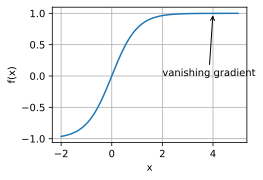

In [7]:
x = torch.arange(-2.0, 5.0, 0.01)
d2l.plot(x, [torch.tanh(x)], 'x', 'f(x)')
annotate('vanishing gradient', (4, 1), (2, 0.0))

Tối ưu trong học sâu mang đầy thử thách. May mắn thay, có khá nhiều thuật toán hoạt động tốt và dễ sử dụng ngay cả đối với người mới bắt đầu. Hơn nữa, việc tìm kiếm *giải pháp tốt nhất là không thật cần thiết*. Các cực tiểu và ngay cả nghiệm xấp xỉ cũng đã rất hữu dụng rồi.

### 11.5.1. Tóm tắt
* Cực tiểu hóa lỗi huấn luyện không đảm bảo việc ta sẽ tìm ra tập tham số tốt nhất để cực tiểu hóa lỗi khái quát.
* Các bài toán tối ưu thường có nhiều vùng cực tiểu.
* Và do các bài toán thường không có tính lồi, số lượng điểm yên ngựa thậm chí có thể nhiều hơn.
* Tiêu biến gradient có thể khiến cho quá trình tối ưu bị đình trệ. Thường thì việc tái tham số hóa bài toán (**reparameterization**) và khởi tạo tham số cẩn thận cũng sẽ giúp ích.

### 11.5.2. Bài tập
1. Xét một mạng perceptron đa tầng đơn giản với một tầng ẩn  $d$  chiều và một đầu ra duy nhất. Chỉ ra rằng bất kỳ cực tiểu nào cũng có ít nhất  $d$!  nghiệm tương đương khiến mạng vận hành giống nhau.
2. Giả sử ta có một ma trận đối xứng $\mathbf{M}$  ngẫu nhiên, trong đó mỗi phần tử  $M_{ij} = M_{ji}$  tuân theo phân phối xác suất  $p_{ij}$ . Ngoài ra, giả sử  $p_{ij}(x) = p_{ij}(-x)$ , tức phân phối là đối xứng (xem [Wigner, 1958] để biết thêm chi tiết).
    * Chứng minh rằng phân phối của các trị riêng cũng là đối xứng, tức với mọi vector riêng  $\mathbf{v}$ , trị riêng  $λ$  tương ứng thoả mãn  $P(\lambda > 0) = P(\lambda < 0)$ .
    * Tại sao điều trên không có nghĩa là  $P(\lambda > 0) = 0.5$ ?
3. Liệu còn thử thách tối ưu nào trong học sâu không?
4. Giả sử bạn muốn cân bằng một quả bóng (thật) trên một chiếc yên ngựa (thật).
    * Tại sao điều này lại khó khăn?
    * Hãy vận dụng kết quả trên vào các thuật toán tối ưu.

## 11.6. Tính lồi
Tính lồi đóng vai trò then chốt trong việc thiết kế các thuật toán tối ưu. Điều này phần lớn là do tính lồi giúp việc phân tích và kiểm tra thuật toán trở nên dễ dàng hơn. Nói cách khác, nếu thuật toán hoạt động kém ngay cả khi có tính lồi thì ta không nên kì vọng rằng sẽ thu được kết quả tốt trong trường hợp khác. Hơn nữa, mặc dù các bài toán tối ưu hóa trong học sâu đa phần là không lồi, chúng lại thường thể hiện một số tính chất lồi gần các cực tiểu. Điều này dẫn đến các biến thể tối ưu hóa thú vị mới như [Izmailov et al., 2018](https://arxiv.org/abs/1803.05407).

### 11.6.1. Kiến thức Cơ bản
Chúng ta hãy bắt đầu với các kiến thức cơ bản trước.

### 11.6.1.1. Tập hợp
Tập hợp là nền tảng của tính lồi. Nói một cách đơn giản, một tập hợp  $X$  trong không gian vector là lồi nếu với bất kì  $a, b \in X$ , đoạn thẳng nối  $a$  và  $b$  cũng thuộc  $X$ . Theo thuật ngữ toán học, điều này có nghĩa là với mọi  $λ∈[0,1]$ , ta có

<center>$\lambda \cdot a + (1-\lambda) \cdot b \in X$ với mọi $a, b \in X$</center>
 
Điều này nghe có vẻ hơi trừu tượng. Hãy xem qua bức ảnh Fig. 11.6.1. Tập hợp đầu tiên là không lồi do tồn tại các đoạn thẳng không nằm trong tập hợp. Hai tập hợp còn lại thì không gặp vấn đề như vậy.

![](images/pacman.svg)
<center>Fig. 11.6.1 Ba hình dạng, hình bên trái là không lồi, hai hình còn lại là lồi</center>

Chỉ một mình định nghĩa thôi thì sẽ không có tác dụng gì trừ khi bạn có thể làm gì đó với chúng. Trong trường hợp này, ta có thể nhìn vào phép hợp và phép giao trong Fig. 11.6.2. Giả sử  $X$  và  $Y$  là các tập hợp lồi, khi đó $X∩Y$  cũng sẽ lồi. Để thấy được điều này, hãy xét bất kì  $a,b∈X∩Y$ . Vì  $X$  và  $Y$  lồi, khi đó đoạn thẳng nối  $a$  và  $b$  sẽ nằm trong cả  $X$  và  $Y$ . Do đó, chúng cũng cần phải thuộc  $X∩Y$ , từ đó chứng minh được định lý đầu tiên của chúng ta.

![](images/convex-intersect.svg)
<center>Fig. 11.6.2 Giao của hai tập lồi là một tập lồi</center>

Ta sẽ củng cố kết quả này thêm một chút với mệnh đề: giao của các tập lồi  $X_i$  là một tập lồi . Để thấy rằng điều ngược lại là không đúng, hãy xem xét hai tập hợp không giao nhau  $X∩Y=∅$ . Giờ ta chọn ra  $a∈X$  và  $b∈Y$ . Đoạn thẳng nối  $a$  và  $b$  trong Fig. 11.6.3 chứa một vài phần không thuộc cả $ X$  và  $Y$ , vì chúng ta đã giả định rằng  $X∩Y=∅$ . Do đó đoạn thẳng này cũng không nằm trong  $X∪Y$ , từ đó chứng minh rằng hợp của các tập lồi nói chung không nhất thiết phải là tập lồi.

![](images/nonconvex.svg)
<center>Fig. 11.6.3 Hợp của hai tập lồi không nhất thiết phải là tập lồi</center>

Thông thường, các bài toán trong học sâu đều được định nghĩa trong các miền lồi. Ví dụ  $\mathbb{R}^d$  là tập lồi (xét cho cùng, đoạn thẳng nối hai điểm bất kỳ thuộc  $\mathbb{R}^d$  vẫn thuộc  $\mathbb{R}^d$ ). Trong một vài trường hợp, chúng ta sẽ làm việc với các biến có biên, ví dụ như khối cầu có bán kính  $r$  được định nghĩa bằng  $\{\mathbf{x} | \mathbf{x} \in \mathbb{R}^d \text{ và } \|\mathbf{x}\|_2 \leq r\}$.

### 11.6.1.2. Hàm số
Giờ ta đã biết về tập hợp lồi, ta sẽ làm việc tiếp với các hàm số lồi  $f$ . Cho một tập hợp lồi  $X$ , một hàm số được định nghĩa trên tập đó  $f:X→R$  là hàm lồi nếu với mọi  $x,x′∈X$  và mọi  $λ∈[0,1]$ , ta có

<center>$\lambda f(x) + (1-\lambda) f(x') \geq f(\lambda x + (1-\lambda) x')$</center>
 
Để minh họa cho điều này, chúng ta sẽ vẽ đồ thị của một vài hàm số và kiểm tra xem hàm số nào thỏa mãn điều kiện trên. Ta sẽ cần phải nhập một vài gói thư viện.

In [1]:
%matplotlib inline
from d2l import torch as d2l
import numpy as np
from mpl_toolkits import mplot3d
import torch

Hãy định nghĩa một vài hàm số, cả lồi lẫn không lồi.

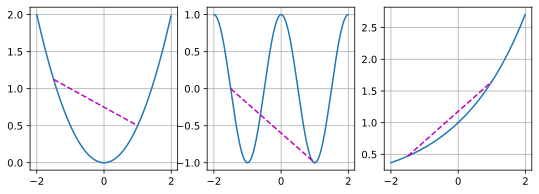

In [2]:
f = lambda x: 0.5 * x**2  # Convex
g = lambda x: torch.cos(np.pi * x)  # Nonconvex
h = lambda x: torch.exp(0.5 * x)  # Convex

x, segment = torch.arange(-2, 2, 0.01), torch.tensor([-1.5, 1])
d2l.use_svg_display()
_, axes = d2l.plt.subplots(1, 3, figsize=(9, 3))
for ax, func in zip(axes, [f, g, h]):
    d2l.plot([x, segment], [func(x), func(segment)], axes=ax)

Như dự đoán, hàm cô-sin là hàm không lồi, trong khi hàm parabol và hàm số mũ là hàm lồi. Lưu ý rằng để điều kiện trên có ý nghĩa thì  $X$  cần phải là tập hợp lồi. Nếu không, kết quả của  $f(λx+(1−λ)x′)$  sẽ không được định nghĩa rõ. Các hàm lồi có một số tính chất mong muốn sau.

### 11.6.1.3. Bất đẳng thức Jensen
Một trong những công cụ hữu dụng nhất là bất đẳng thức Jensen. Nó là sự tổng quát hóa của định nghĩa về tính lồi:

\begin{aligned}
    \sum_i \alpha_i f(x_i) & \geq f\left(\sum_i \alpha_i x_i\right)
    \text{ và }
    E_x[f(x)] & \geq f\left(E_x[x]\right),
\end{aligned}
 
với  $\alpha_i$  là các số thực không âm sao cho  $\sum_i \alpha_i = 1$ . Nói cách khác, kỳ vọng của hàm lồi lớn hơn hàm lồi của kỳ vọng. Để chứng minh bất đẳng thức đầu tiên này, chúng ta áp dụng định nghĩa của tính lồi cho từng số hạng của tổng. Kỳ vọng có thể được chứng minh bằng cách tính giới hạn trên các đoạn hữu hạn.

Một trong các ứng dụng phổ biến của bất đẳng thức Jensen liên quan đến log hợp lý của các biến ngẫu nhiên quan sát được một phần. Ta có

<center>$E_{y \sim P(y)}[-\log P(x \mid y)] \geq -\log P(x)$</center>
 
Điều này xảy ra vì  $\int P(y) P(x \mid y) dy = P(x)$ . Nó được sử dụng trong những phương pháp biến phân.  $y$  ở đây thường là một biến ngẫu nhiên không quan sát được,  $P(y)$  là dự đoán tốt nhất về phân phối của nó và  $P(x)$  là phân phối đã được lấy tích phân theo  $y$ . Ví dụ như trong bài toán phân cụm,  $y$  có thể là nhãn cụm và  $P(x∣y)$  là mô hình sinh khi áp dụng các nhãn cụm.

### 11.6.2. Tính chất
Các hàm lồi có một vài tính chất hữu ích dưới đây.

### 11.6.2.1. Không có Cực tiểu Cục bộ
Cụ thể, các hàm lồi không có cực tiểu cục bộ. Hãy giả định điều ngược lại là đúng và chứng minh nó sai. Nếu  $x∈X$  là cực tiểu cục bộ thì sẽ tồn tại một vùng lân cận nào đó của  $x$  mà  $f(x)$  là giá trị nhỏ nhất. Vì  $x$  chỉ là cực tiểu cục bộ nên phải tồn tại một  $x′∈X$  nào khác mà  $f(x′)<f(x)$ . Tuy nhiên, theo tính lồi, các giá trị hàm số trên toàn bộ đường thẳng  $λx+(1−λ)x′$  phải nhỏ hơn  $f(x′)$  với  $λ∈[0,1)$ 

<center>$f(x)>λf(x)+(1−λ)f(x′)≥f(λx+(1−λ)x′)$</center>
 
Điều này mâu thuẫn với giả định rằng  $f(x)$  là cực tiểu cục bộ. Ví dụ, hàm  $f(x)=(x+1)(x−1)^2$  có cực tiểu cục bộ tại  $x=1$ . Tuy nhiên nó lại không phải là cực tiểu toàn cục.

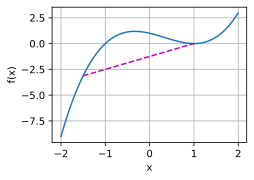

In [3]:
f = lambda x: (x-1)**2 * (x+1)
d2l.set_figsize()
d2l.plot([x, segment], [f(x), f(segment)], 'x', 'f(x)')

Tính chất “**các hàm lồi không có cực tiểu cục bộ**” rất tiện lợi. Điều này có nghĩa là ta sẽ không bao giờ “mắc kẹt” khi cực tiểu hóa các hàm số. Dù vậy, hãy lưu ý rằng điều này không có nghĩa là hàm số không thể có nhiều hơn một cực tiểu toàn cục, hoặc liệu hàm số có tồn tại cực tiểu toàn cục hay không. Ví dụ, hàm  $f(x)=max(|x|−1,0)$  đạt giá trị nhỏ nhất trên khoảng  $[−1,1]$ . Ngược lại, hàm  $f(x)=exp(x)$  không có giá trị nhỏ nhất trên  $\mathbb{R}$ . Với  $x \to -\infty$  nó sẽ tiệm cận tới  $0$ , tuy nhiên không tồn tại giá trị  $x$  mà tại đó  $f(x)=0$ .

### 11.6.2.2. Hàm số và Tập hợp Lồi¶
Các hàm số lồi định nghĩa các tập hợp lồi là các *tập-dưới* (**below-sets**) như sau:

<center>$S_b := \{x | x \in X \text{ and } f(x) \leq b\}$</center>
 
Ta hãy chứng minh nó một cách vắn tắt. Hãy nhớ rằng với mọi  $x,x′∈S_b$ , ta cần chứng minh  $λx+(1−λ)x′∈S_b$  với mọi  $λ∈[0,1]$ . Nhưng điều này lại trực tiếp tuân theo định nghĩa về tính lồi vì  $f(λx+(1−λ)x′)≤λf(x)+(1−λ)f(x′)≤b$ .

Hãy nhìn vào đồ thị hàm  $f(x,y)=0.5x^2+cos(2πy)$  bên dưới. Nó rõ ràng là không lồi. Các tập mức tương ứng cũng không lồi. Thực tế, chúng thường được cấu thành từ các tập hợp rời rạc.

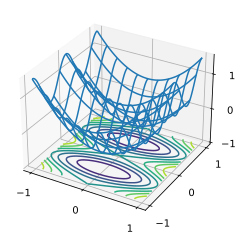

In [4]:
x, y = torch.meshgrid(
    torch.linspace(-1.0, 1.0, 101), torch.linspace(-1.0, 1.0, 101))
z = x**2 + 0.5 * torch.cos(2 * np.pi * y)
# Plot the 3D surface
d2l.set_figsize((6, 4))
ax = d2l.plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 10, 'cstride': 10})
ax.contour(x, y, z, offset=-1)
ax.set_zlim(-1, 1.5)
# Adjust labels
for func in [d2l.plt.xticks, d2l.plt.yticks, ax.set_zticks]:
    func([-1, 0, 1])

### 11.6.2.3. Đạo hàm và tính Lồi
Bất cứ khi nào đạo hàm bậc hai của một hàm số tồn tại, việc kiểm tra tính lồi của hàm số là rất đơn giản. Tất cả những gì cần làm là kiểm tra liệu  $\partial_x^2 f(x) \succeq 0$ , tức là liệu toàn bộ trị riêng của nó đều không âm hay không. Chẳng hạn, hàm  $f(\mathbf{x}) = \frac{1}{2} \|\mathbf{x}\|^2_2$  là lồi vì  $\partial_{\mathbf{x}}^2 f = \mathbf{1}$ , tức là đạo hàm của nó là ma trận đơn vị.

Có thể nhận ra rằng chúng ta chỉ cần chứng minh tính chất này cho các hàm số một chiều. Xét cho cùng, ta luôn có thể định nghĩa một hàm số  $g(z) = f(\mathbf{x} + z \cdot \mathbf{v})$ . Hàm số này có đạo hàm bậc một và bậc hai lần lượt là  $g' = (\partial_{\mathbf{x}} f)^\top \mathbf{v}$  và  $g'' = \mathbf{v}^\top (\partial^2_{\mathbf{x}} f) \mathbf{v}$. Cụ thể,  $g′′≥0$  với mọi  $v$  mỗi khi ma trận Hessian của  $f$  là nửa xác định dương, tức là tất cả các trị riêng của ma trận đều lớn hơn hoặc bằng không. Do đó quay về lại trường hợp vô hướng.

Để thấy tại sao  $f′′(x)≥0$  đối với các hàm lồi, ta dùng lập luận

<center>$\frac{1}{2} f(x + \epsilon) + \frac{1}{2} f(x - \epsilon) \geq f\left(\frac{x + \epsilon}{2} + \frac{x - \epsilon}{2}\right) = f(x).$</center>
 
Vì đạo hàm bậc hai được đưa ra bởi giới hạn trên sai phân hữu hạn, nó dẫn tới

<center>$f''(x) = \lim_{\epsilon \to 0} \frac{f(x+\epsilon) + f(x - \epsilon) - 2f(x)}{\epsilon^2} \geq 0.$</center>
 
Để chứng minh điều ngược lại, ta dùng lập luận rằng  $f′′≥0$  ngụ ý rằng  $f′$  là một hàm tăng đơn điệu. Cho  $a<x<b$  là ba điểm thuộc $\mathbb{R}$ . Chúng ta sử dụng định lý giá trị trung bình để biểu diễn

\begin{split}\begin{aligned}
f(x) - f(a) & = (x-a) f'(\alpha) \text{ với } \alpha \in [a, x] \text{ và } \\
f(b) - f(x) & = (b-x) f'(\beta) \text{ với } \beta \in [x, b].
\end{aligned}\end{split}
 
Từ tính chất đơn điệu  $f′(β)≥f′(α)$ , ta có

\begin{split}\begin{aligned}
    f(b) - f(a) & = f(b) - f(x) + f(x) - f(a) \\
    & = (b-x) f'(\beta) + (x-a) f'(\alpha) \\
    & \geq (b-a) f'(\alpha).
\end{aligned}\end{split}
 
Theo hình học, nó dẫn đến  $f(x)$  nằm dưới đường thẳng nối  $f(a)$  và  $f(b)$ , do đó chứng minh được tính lồi. Ta sẽ bỏ qua việc chứng minh một cách chính quy và thay bằng đồ thị bên dưới.

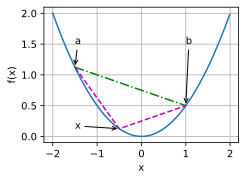

In [5]:
f = lambda x: 0.5 * x**2
x = torch.arange(-2, 2, 0.01)
axb, ab = torch.tensor([-1.5, -0.5, 1]), torch.tensor([-1.5, 1])
d2l.set_figsize()
d2l.plot([x, axb, ab], [f(x) for x in [x, axb, ab]], 'x', 'f(x)')
d2l.annotate('a', (-1.5, f(-1.5)), (-1.5, 1.5))
d2l.annotate('b', (1, f(1)), (1, 1.5))
d2l.annotate('x', (-0.5, f(-0.5)), (-1.5, f(-0.5)))

### 11.6.3. Ràng buộc
Một trong những tính chất hữu ích của tối ưu hóa lồi là nó cho phép chúng ta xử lý các ràng buộc một cách hiệu quả. Nó cho phép ta giải quyết các bài toán dưới dạng:

<center>cực tiểu hóa $f(x)$ theo $c_i(x)≤0$ với mọi $i∈{1,…,N}$</center>
 
$f$  ở đây là mục tiêu và các hàm  $c_i$  là các hàm số ràng buộc. Hãy xem nó xử lý thế nào trong trường hợp $c_1(\mathbf{x}) = \|\mathbf{x}\|_2 - 1$ . Ở trường hợp này, các tham số  $x$  bị ràng buộc vào khối cầu đơn vị. Nếu ràng buộc thứ hai là  $c_2(\mathbf{x}) = \mathbf{v}^\top \mathbf{x} + b$ thì điều này ứng với mọi  $x$  nằm trên nửa khoảng. Đáp ứng đồng thời hai ràng buộc này nghĩa là chọn ra một lát cắt của khối cầu làm tập hợp ràng buộc.

### 11.6.3.1. Hàm số Lagrange
Nhìn chung, giải quyết một bài toán tối ưu hóa bị ràng buộc là tương đối khó khăn. Có một cách giải quyết bắt nguồn từ vật lý dựa trên một trực giác khá đơn giản. Hãy tưởng tượng có một quả banh bên trong một chiếc hộp. Quả banh sẽ lăn đến nơi thấp nhất và trọng lực sẽ cân bằng với lực nâng của các cạnh hộp tác động lên quả banh. Tóm lại, gradient của hàm mục tiêu (ở đây là trọng lực) sẽ được bù lại bởi gradient của hàm ràng buộc (cần phải nằm trong chiếc hộp, bị các bức tưởng “đẩy lại”). Lưu ý rằng bất kỳ ràng buộc nào không kích hoạt (quả banh không đụng đến bức tường) thì sẽ không có bất kỳ một lực tác động nào lên quả banh.

Ta hãy bỏ qua phần diễn giải chứng minh của hàm số Lagrange  L  (Xem sách của Boyd và Vandenberghe về vấn đề này [Boyd & Vandenberghe, 2004]). Lý luận bên trên có thể được mô tả thông qua bài toán tối ưu hóa điểm yên ngựa:

<center>$L(\mathbf{x},\alpha) = f(\mathbf{x}) + \sum_i \alpha_i c_i(\mathbf{x}) \text{ với } \alpha_i \geq 0$</center>
 
Các biến  $α_i$  ở đây được gọi là nhân tử Lagrange (Lagrange Multipliers), chúng đảm bảo rằng các ràng buộc sẽ được tuân thủ đàng hoàng. Chúng được chọn vừa đủ lớn để đảm bảo rằng  $c_i(x)≤0$  với mọi  $i$ . Ví dụ, với mọi  $x$  mà  $c_i(x)<0 $ một cách tự nhiên, chúng ta rốt cuộc sẽ chọn  $α_i=0$ . Hơn nữa, đây là bài toán tối ưu hóa điểm yên ngựa, nơi ta muốn cực đại hóa $ L$  theo  $α$  và đồng thời cực tiểu hóa nó theo  $x$ . Có rất nhiều tài liệu giải thích về cách đưa đến hàm  $L(x,α)$ . Đối với mục đích của chúng ta, sẽ là đủ khi biết rằng điểm yên ngựa của $ L$  là nơi bài toán tối ưu hóa bị ràng buộc ban đầu được giải quyết một cách tối ưu.

### 11.6.3.2. Lượng phạt
Có một cách để thỏa mãn, ít nhất là theo xấp xỉ, các bài toán tối ưu hóa bị ràng buộc là phỏng theo hàm Lagrange  $L$ . Thay vì thỏa mãn  $c_i(x)≤0$ , chúng ta chỉ cần thêm  $α_ic_i(x)$  vào hàm mục tiêu  $f(x)$ . Điều này sẽ đảm bảo rằng các ràng buộc không bị vi phạm quá mức.

Thực tế, chúng ta đã dùng thủ thuật này khá thường xuyên. Hãy xét đến suy giảm trọng số trong Section 4.5. Ở đó chúng ta thêm  $\frac{\lambda}{2} \|\mathbf{w}\|^2$  vào hàm mục tiêu để đảm bảo rằng giá trị  $w$  không trở nên quá lớn. Dưới góc nhìn tối ưu hóa có ràng buộc, ta có thể thấy nó sẽ đảm bảo  $\|\mathbf{w}\|^2 - r^2 \leq 0$  với giá trị bán kính  $r$  nào đó. Điều chỉnh giá trị của  $λ$  cho phép chúng ta thay đổi độ lớn của  $\mathbf{w}$ .

Nhìn chung, thêm các lượng phạt là một cách tốt để đảm bảo việc thỏa mãn ràng buộc xấp xỉ. Trong thực tế, hóa ra phương pháp này ổn định hơn rất nhiều so với trường hợp thỏa mãn chuẩn xác. Hơn nữa, với các bài toán không lồi, những tính chất khiến phương án tiếp cận chuẩn xác trở nên rất thu hút trong trường hợp lồi (ví dụ như tính tối ưu) không còn đảm bảo nữa.

### 11.6.3.3. Các phép chiếu
Một chiến lược khác để thỏa mãn các ràng buộc là các phép chiếu. Chúng ta cũng đã gặp chúng trước đây, ví dụ như khi bàn về phương pháp gọt gradient ở Section 8.5. Ở phần đó chúng ta đã đảm bảo rằng gradient có độ dài ràng buộc bởi  c  thông qua

<center>$\mathbf{g} \leftarrow \mathbf{g} \cdot \mathrm{min}(1, c/\|\mathbf{g}\|).$</center>
 
Hóa ra đây là một phép chiếu của  g  lên khối cầu có bán kính  c . Tổng quát hơn, một phép chiếu lên một tập (lồi)  X  được định nghĩa là

<center>$\mathrm{Proj}_X(\mathbf{x}) = \mathop{\mathrm{argmin}}_{\mathbf{x}' \in X} \|\mathbf{x} - \mathbf{x}'\|_2.$</center>
 
Do đó đây là điểm gần nhất trong  $X$  tới  $x$ . Điều này nghe có vẻ hơi trừu tượng. Fig. 11.6.4 sẽ giải thích nó một cách rõ ràng hơn. Ở đó ta có hai tập lồi, một hình tròn và một hình thoi. Các điểm nằm bên trong tập (màu vàng) giữ nguyên không đổi. Các điểm nằm bên ngoài tập (màu đen) được ánh xạ tới điểm gần nhất bên trong tập (màu đỏ). Trong khi với các khối cầu  $ℓ_2 $ hướng của phép chiếu được giữ nguyên không đổi, điều này có thể không đúng trong trường hợp tổng quát, như có thể thấy trong trường hợp của hình thoi.

![](images/projections.svg)
<center>Fig. 11.6.4 Các phép chiếu lồi</center>

Một trong những ứng dụng của các phép chiếu lồi là để tính toán các vector trọng số thưa. Trong trường hợp này chúng ta chiếu  $w$  lên khối cầu  $ℓ_1$  (phiên bản tổng quát của hình thoi ở hình minh họa phía trên).

### 11.6.4. Tóm tắt
Trong bối cảnh học sâu, mục đích chính của các hàm lồi là để thúc đẩy sự phát triển các thuật toán tối ưu hóa và giúp ta hiểu chúng một cách chi tiết. Phần tiếp theo chúng ta sẽ thấy cách mà hạ gradient và hạ gradient ngẫu nhiên có thể được suy ra từ đó.

* Giao của các tập lồi là tập lồi. Hợp của các tập lồi không bắt buộc phải là tập lồi.
* Kỳ vọng của hàm lồi lớn hơn hàm lồi của kỳ vọng (Bất đẳng thức Jensen).
* Hàm khả vi hai lần là hàm lồi khi và chỉ khi đạo hàm bậc hai của nó chỉ có các trị riêng không âm ở mọi nơi.
* Các ràng buộc lồi có thể được thêm vào hàm Lagrange. Trong thực tế, ta chỉ việc thêm chúng cùng với một mức phạt vào hàm mục tiêu.
* Các phép chiếu ánh xạ đến các điểm trong tập (lồi) nằm gần nhất với điểm gốc.

### 11.6.5. Bài tập
1. Giả sử chúng ta muốn xác minh tính lồi của tập hợp bằng cách vẽ mọi đoạn thẳng giữa các điểm bên trong tập hợp và kiểm tra liệu các đoạn thẳng có nằm trong tập hợp đó hay không.
    * Hãy chứng mình rằng ta chỉ cần kiểm tra các điểm ở biên là đủ.
    * Hãy chứng minh rằng ta chỉ cần kiểm tra các đỉnh của tập hợp là đủ.
2. Ký hiệu khối cầu có bán kính  $r$  sử dụng chuẩn  $p$  là $B_p[r] := \{\mathbf{x} | \mathbf{x} \in \mathbb{R}^d \text{ và } \|\mathbf{x}\|_p \leq r\}$ . Hãy chứng minh rằng  $B_p[r]$  là lồi với mọi  $p≥1$ .
3. Cho các hàm lồi  $f$  và  $g$  sao cho  $max(f,g)$  cũng là hàm lồi. Hãy chứng minh rằng  $min(f,g)$  không lồi.
4. Hãy chứng minh rằng hàm softmax được chuẩn hóa là hàm lồi. Cụ thể hơn, chứng minh tính lồi của  $f(x) = \log \sum_i \exp(x_i)$ .
5. Hãy chứng minh rằng các không gian con tuyến tính là các tập lồi. Ví dụ,  $X = \{\mathbf{x} | \mathbf{W} \mathbf{x} = \mathbf{b}\}$ .
6. Hãy chứng minh rằng trong trường hợp của các không gian con tuyến tính với  $b=0$ , phép chiếu  $\mathrm{Proj}_X$  có thể được viết dưới dạng  $\mathbf{M} \mathbf{x}$  với một ma trận  $\mathbf{M}$  nào đó.
7. Hãy chỉ ra rằng với các hàm số khả vi hai lần  $f$ , ta có thể viết $f(x + \epsilon) = f(x) + \epsilon f'(x) + \frac{1}{2} \epsilon^2 f''(x + \xi)$  với một giá trị  $ξ∈[0,ϵ]$  nào đó.
8. Cho vector  $\mathbf{w} \in \mathbb{R}^d$  với  $∥w∥_1>1$ , hãy tính phép chiếu lên khối cầu đơn vị  $ℓ_1$ .
    * Như một bước trung gian, hãy viết ra mục tiêu có lượng phạt  $\|\mathbf{w} - \mathbf{w}'\|_2^2 + \lambda \|\mathbf{w}'\|_1$  và tính ra đáp án với  $λ>0$ .
    * Bạn có thể tìm ra giá trị ‘chính xác’ của $λ$  mà không phải đoán mò quá nhiều lần không?
9. Cho tập lồi  $X$  và hai vector  $x$ ,  $y$ , hãy chứng minh rằng các phép chiếu không bao giờ làm tăng khoảng cách, ví dụ,  $\|\mathbf{x} - \mathbf{y}\| \geq \|\mathrm{Proj}_X(\mathbf{x}) - \mathrm{Proj}_X(\mathbf{y})\|$ .

## 11.7. Hạ Gradient
Trong phần này chúng tôi sẽ giới thiệu các khái niệm cơ bản trong thuật toán hạ gradient. Nội dung cần thiết sẽ được trình bày ngắn gọn. Độc giả có thể tham khảo [Boyd & Vandenberghe, 2004](https://www.cambridge.org/core/books/convex-optimization/17D2FAA54F641A2F62C7CCD01DFA97C4) để có góc nhìn sâu về bài toán tối ưu lồi. Mặc dù tối ưu lồi hiếm khi được áp dụng trực tiếp trong học sâu, kiến thức về thuật toán hạ gradient là chìa khóa để hiểu rõ hơn về thuật toán hạ gradient ngẫu nhiên. Ví dụ, bài toán tối ưu có thể phân kỳ do tốc độ học quá lớn. Hiện tượng này có thể quan sát được trong thuật toán hạ gradient. Tương tự, tiền điều kiện (preconditioning) là một kỹ thuật phổ biến trong thuật toán hạ gradient và nó cũng được áp dụng trong các thuật toán tân tiến hơn. Hãy bắt đầu với một trường hợp đặc biệt và đơn giản.

### 11.7.1. Hạ Gradient trong Một Chiều
Hạ gradient trong một chiều là ví dụ tuyệt vời để giải thích tại sao thuật toán hạ gradient có thể giảm giá trị hàm mục tiêu. Hãy xem xét một hàm số thực khả vi liên tục  $f: \mathbb{R} \rightarrow \mathbb{R}$ . Áp dụng khai triển Taylor (Section 18.3), ta có

$f(x + \epsilon) = f(x) + \epsilon f'(x) + \mathcal{O}(\epsilon^2)$
 
Trong đó xấp xỉ bậc nhất  $f(x+ϵ)$  được tính bằng giá trị hàm  $f(x)$  và đạo hàm bậc nhất  $f′(x)$  tại $ x$ . Có lý khi giả sử rằng di chuyển theo hướng ngược chiều gradient với  $ϵ$  nhỏ sẽ làm suy giảm giá trị  $f$ . Để đơn giản hóa vấn đề, ta cố định sải bước cập nhật (tốc độ học) $ η>0$  và chọn  $ϵ=−ηf′(x)$ . Thay biểu thức này vào khai triển Taylor ở trên, ta thu được

$f(x - \eta f'(x)) = f(x) - \eta f'^2(x) + \mathcal{O}(\eta^2 f'^2(x)).$
 
Nếu đạo hàm  $f′(x)≠0$  không tiêu biến, quá trình tối ưu sẽ có tiến triển do  $ηf′^2(x)>0$ .
Hơn nữa, chúng ta luôn có thể chọn  $η$  đủ nhỏ để loại bỏ các hạng tử bậc cao hơn trong phép cập nhật. Do đó, ta có

$f(x - \eta f'(x)) \lessapprox f(x).$
 
Điều này có nghĩa là, nếu chúng ta áp dụng


$x \leftarrow x - \eta f'(x)$
 
để cập nhật  $x$ , giá trị của hàm  $f(x)$  có thể giảm. Do đó, trong thuật toán hạ gradient, đầu tiên chúng ta chọn giá trị khởi tạo cho  $x $ và hằng số  $η>0$ , từ đó cập nhật giá trị  $x$  liên tục cho tới khi thỏa mãn điều kiện dừng, ví dụ như khi độ lớn của gradient $ |f′(x)|$  đủ nhỏ hoặc số lần cập nhật đạt một ngưỡng nhất định.

Để đơn giản hóa vấn đề, chúng ta chọn hàm mục tiêu  $f(x)=x^2 $ để minh họa cách lập trình thuật toán hạ gradient. Ta sử dụng ví dụ đơn giản này để quan sát cách mà  $x$  thay đổi, dù đã biết rằng  $x=0$  là nghiệm để cực tiểu hóa  $f(x)$ . Như mọi khi, chúng ta bắt đầu bằng cách nhập tất cả các mô-đun cần thiết.

In [1]:
%matplotlib inline
from d2l import torch as d2l
import numpy as np
import torch

f = lambda x: x**2  # Objective function
gradf = lambda x: 2 * x  # Its derivative

Tiếp theo, chúng ta sử dụng  $x=10$  làm giá trị khởi tạo và chọn  $η=0.2$ . Áp dụng thuật toán hạ gradient để cập nhật  $x$  trong 10 vòng lặp, chúng ta có thể thấy cuối cùng giá trị của  $x$  cũng tiệm cận nghiệm tối ưu.

In [2]:
def gd(eta):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * gradf(x)
        results.append(float(x))
    print('epoch 10, x:', x)
    return results

res = gd(0.2)

epoch 10, x: 0.06046617599999997


Đồ thị quá trình tối ưu hóa theo  $x$  được vẽ như sau.

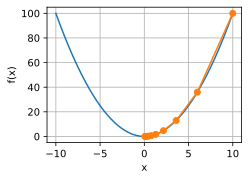

In [3]:
def show_trace(res):
    n = max(abs(min(res)), abs(max(res)))
    f_line = torch.arange(-n, n, 0.01)
    d2l.set_figsize()
    d2l.plot([f_line, res], [[f(x) for x in f_line], [f(x) for x in res]],
             'x', 'f(x)', fmts=['-', '-o'])

show_trace(res)

### 11.7.1.1. Tốc độ học
Tốc độ học  $η$  có thể được thiết lập khi thiết kế thuật toán. Nếu ta sử dụng tốc độ học quá nhỏ thì  $x$  sẽ được cập nhật rất chậm, đòi hỏi số bước cập nhật nhiều hơn để thu được nghiệm tốt hơn. Để minh họa, hãy xem xét quá trình học trong cùng bài toán tối ưu ở phía trên với  $η=0.05$ . Như chúng ta có thể thấy, ngay cả sau 10 bước cập nhật, chúng ta vẫn còn ở rất xa nghiệm tối ưu.

epoch 10, x: 3.4867844009999995


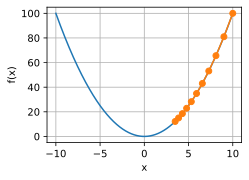

In [4]:
show_trace(gd(0.05))

Ngược lại, nếu ta sử dụng tốc độ học quá cao, giá trị  $|ηf′(x)|$  có thể rất lớn trong khai triển Taylor bậc nhất. Cụ thể, hạng tử  $\mathcal{O}(\eta^2 f'^2(x))$  trong $:eqref: gd-taylor$ sẽ có thể có giá trị lớn. Trong trường hợp này, ta không thể đảm bảo rằng việc cập nhật  $x$  sẽ có thể làm suy giảm giá trị của  $f(x)$ . Ví dụ, khi chúng ta thiết lập tốc độ học  $η=1.1$ ,  $x$  sẽ lệch rất xa so với nghiệm tối ưu  $x=0$  và dần dần phân kỳ.

epoch 10, x: 61.917364224000096


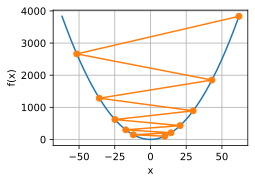

In [5]:
show_trace(gd(1.1))

### 11.7.1.2. Cực Tiểu
Để minh họa quá trình học các hàm không lồi, ta xem xét trường hợp  $f(x)=x⋅coscx$ . Hàm này có vô số cực tiểu. Tùy thuộc vào tốc độ học được chọn và điều kiện của bài toán, chúng ta có thể thu được một trong số rất nhiều nghiệm. Ví dụ dưới đây minh họa việc thiết lập tốc độ học quá cao (không thực tế) sẽ dẫn đến điểm cực tiểu không tốt.

epoch 10, x: tensor(-1.5282)


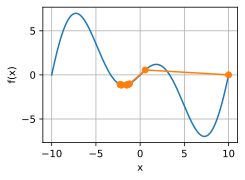

In [6]:
c = torch.tensor(0.15 * np.pi)
f = lambda x: x * torch.cos(c * x)
gradf = lambda x: torch.cos(c * x) - c * x * torch.sin(c * x)
show_trace(gd(2))

### 11.7.2. Hạ Gradient Đa biến
Bây giờ chúng ta đã có trực quan tốt hơn về trường hợp đơn biến, ta hãy xem xét trường hợp trong đó  x∈Rd . Cụ thể, hàm mục tiêu  f:Rd→R  ánh xạ các vector tới các giá trị vô hướng. Gradient tương ứng cũng là đa biến, là một vector gồm  d  đạo hàm riêng:

<center>$\nabla f(\mathbf{x}) = \bigg[\frac{\partial f(\mathbf{x})}{\partial x_1}, \frac{\partial f(\mathbf{x})}{\partial x_2}, \ldots, \frac{\partial f(\mathbf{x})}{\partial x_d}\bigg]^\top.$</center>
 
Mỗi đạo hàm riêng  ∂f(x)/∂xi  trong gradient biểu diễn tốc độ thay đổi theo  xi  của  f  tại  x . Như trong trường hợp đơn biến giới thiệu ở phần trước, ta sử dụng khai triển Taylor tương ứng cho các hàm đa biến. Cụ thể, ta có

<center>$f(\mathbf{x} + \mathbf{\epsilon}) = f(\mathbf{x}) + \mathbf{\epsilon}^\top \nabla f(\mathbf{x}) + \mathcal{O}(\|\mathbf{\epsilon}\|^2).$</center>
 
Nói cách khác, chiều giảm mạnh nhất được cho bởi gradient âm $-\nabla f(\mathbf{x})$ , các hạng tử từ bậc hai trở lên trong  $ϵ$  có thể bỏ qua. Chọn một tốc độ học phù hợp  $η>0$ , ta được thuật toán hạ gradient nguyên bản dưới đây:

<center>$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f(\mathbf{x}).$</center>
 
Để xem thuật toán hoạt động như thế nào trong thực tế, ta hãy xây dựng một hàm mục tiêu  $f(x)=x_1^2+2x_2^2$  với đầu vào là vector hai chiều  $x=[x1,x2]^⊤$  và đầu ra là một số vô hướng. Gradient được cho bởi  $∇f(x)=[2x_1,4x_2]^⊤$ . Ta sẽ quan sát đường đi của  $x$  được sinh bởi thuật toán hạ gradient bắt đầu từ vị trí  $[−5,−2]$ . Chúng ta cần thêm hai hàm hỗ trợ. Hàm đầu tiên là hàm cập nhật và được sử dụng  20  lần cho giá trị khởi tạo ban đầu. Hàm thứ hai là hàm vẽ biểu đồ đường đi của $ x$ .

In [7]:
def train_2d(trainer, steps=20):  #@save
    """Optimize a 2-dim objective function with a customized trainer."""
    # s1 and s2 are internal state variables and will
    # be used later in the chapter
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    return results

def show_trace_2d(f, results):  #@save
    """Show the trace of 2D variables during optimization."""
    d2l.set_figsize()
    d2l.plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = torch.meshgrid(torch.arange(-5.5, 1.0, 0.1),
                          torch.arange(-3.0, 1.0, 0.1))
    d2l.plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')

Tiếp theo, chúng ta sẽ quan sát quỹ đạo của biến tối ưu hóa  $x$  với tốc độ học  $η=0.1$ . Chúng ta có thể thấy rằng sau 20 bước, giá trị $ x$ đã đạt cực tiểu tại $ [0,0] $. Quá trình khá tốt mặc dù hơi chậm.

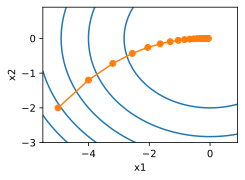

In [8]:
f = lambda x1, x2: x1 ** 2 + 2 * x2 ** 2  # Objective
gradf = lambda x1, x2: (2 * x1, 4 * x2)  # Gradient

def gd(x1, x2, s1, s2):
    (g1, g2) = gradf(x1, x2)  # Compute gradient
    return (x1 - eta * g1, x2 - eta * g2, 0, 0)  # Update variables

eta = 0.1
show_trace_2d(f, train_2d(gd))

### 11.7.3. Những Phương pháp Thích nghi
Như chúng ta có thể thấy ở Section 11.7.1.1, chọn tốc độ học  $η$  “**vừa đủ**” rất khó. Nếu chọn giá trị quá nhỏ, ta sẽ không có tiến triển. Nếu chọn giá trị quá lớn, nghiệm sẽ dao động và trong trường hợp tệ nhất, thậm chí sẽ phân kỳ. Sẽ ra sao nếu chúng ta có thể chọn  η  một cách tự động, hoặc giả như loại bỏ được việc chọn kích thước bước? Các phương pháp bậc hai không chỉ dựa vào giá trị và gradient của hàm mục tiêu mà còn dựa vào “**độ cong**” của hàm, từ đó có thể điều chỉnh tốc độ học. Dù những phương pháp này không thể áp dụng vào học sâu một cách trực tiếp do chi phí tính toán lớn, chúng đem đến những gợi ý hữu ích để thiết kế các thuật toán tối ưu cao cấp hơn, mang nhiều tính chất mong muốn dựa trên các thuật toán dưới đây.

### 11.7.3.1. Phương pháp Newton
Trong khai triển Taylor của  $f$ , ta không cần phải dừng ngay sau số hạng đầu tiên. Trên thực tế, ta có thể viết lại như sau

<center>$f(\mathbf{x} + \mathbf{\epsilon}) = f(\mathbf{x}) + \mathbf{\epsilon}^\top \nabla f(\mathbf{x}) + \frac{1}{2} \mathbf{\epsilon}^\top \nabla \nabla^\top f(\mathbf{x}) \mathbf{\epsilon} + \mathcal{O}(\|\mathbf{\epsilon}\|^3)$</center>
 
Để tránh việc kí hiệu quá nhiều, ta định nghĩa  $H_f := \nabla \nabla^\top f(\mathbf{x})$  là ma trận Hessian của  $f$ . Đây là ma trận kích thước  $d×d$ . Với  $d$  nhỏ và trong các bài toán đơn giản, ta sẽ dễ tính được  $H_f$ . Nhưng với các mạng sâu, kích thước của  $H_f$  có thể cực lớn, do chi phí lưu trữ bậc hai  $\mathcal{O}(d^2)$ . Hơn nữa việc tính toán lan truyền ngược có thể đòi hỏi rất nhiều chi phí tính toán. Tạm thời hãy bỏ qua những lưu ý đó và nhìn vào thuật toán mà ta có được.

Suy cho cùng, cực tiểu của  $f$  sẽ thỏa  $∇f(x)=0$ . Lấy các đạo hàm của (11.7.8) theo  $ϵ$  và bỏ qua các số hạng bậc cao ta thu được

<center>$\nabla f(\mathbf{x}) + H_f \mathbf{\epsilon} = 0 \text{ và do đó }
\mathbf{\epsilon} = -H_f^{-1} \nabla f(\mathbf{x})$</center>
 
Nghĩa là, ta cần phải nghịch đảo ma trận Hessian  Hf  như một phần của bài toán tối ưu hóa.

Với  $f(x) = \frac{1}{2} x^2$ ta có  $∇f(x)=x$  và  $H_f=1$ . Do đó với  $x$  bất kỳ, ta đều thu được  $ϵ=−x$ . Nói cách khác, một bước đơn lẻ là đã đủ để hội tụ một cách hoàn hảo mà không cần bất kỳ tinh chỉnh nào! Chúng ta khá may mắn ở đây vì khai triển Taylor không cần xấp xỉ. Hãy xem thử điều gì sẽ xảy ra với các bài toán khác.

epoch 10, x: tensor(0.)


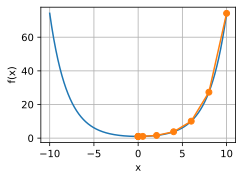

In [9]:
c = torch.tensor(0.5)
f = lambda x: torch.cosh(c * x)  # Objective
gradf = lambda x: c * torch.sinh(c * x)  # Derivative
hessf = lambda x: c**2 * torch.cosh(c * x)  # Hessian

def newton(eta=1):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * gradf(x) / hessf(x)
        results.append(float(x))
    print('epoch 10, x:', x)
    return results

show_trace(newton())

Giờ hãy xem điều gì xảy ra với một hàm *không lồi*, ví dụ như  $f(x)=xcos(cx)$ . Sau tất cả, hãy lưu ý rằng trong phương pháp Newton, chúng ta cuối cùng sẽ phải chia cho ma trận Hessian. Điều này nghĩa là nếu đạo hàm bậc hai là âm thì chúng ta phải đi theo hướng tăng  $f$ . Đó là khiếm khuyết chết người của thuật toán này. Hãy xem điều gì sẽ xảy ra trong thực tế.

epoch 10, x: tensor(26.8341)


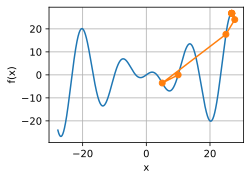

In [10]:
c = torch.tensor(0.15 * np.pi)
f = lambda x: x * torch.cos(c * x)
gradf = lambda x: torch.cos(c * x) - c * x * torch.sin(c * x)
hessf = lambda x: - 2 * c * torch.sin(c * x) - x * c**2 * torch.cos(c * x)

show_trace(newton())

Kết quả trả về là cực kỳ sai. Có một cách khắc phục là “sửa” ma trận Hessian bằng cách lấy giá trị tuyệt đối của nó. Một chiến lược khác là đưa tốc độ học trở lại. Điều này có vẻ sẽ phá hỏng mục tiêu ban đầu nhưng không hẳn. Có được thông tin bậc hai sẽ cho phép chúng ta thận trọng bất cứ khi nào độ cong trở nên lớn và cho phép thực hiện các bước dài hơn mỗi khi hàm mục tiêu phẳng. Hãy xem nó hoạt động như thế nào với một tốc độ học khá nhỏ,  $η=0.5$  chẳng hạn. Như ta có thể thấy, chúng ta có một thuật toán khá hiệu quả.

epoch 10, x: tensor(7.2699)


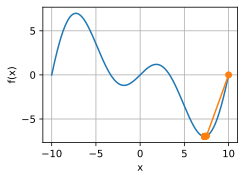

In [11]:
show_trace(newton(0.5))

### 11.7.3.2. Phân tích Hội tụ
Chúng ta sẽ chỉ phân tích tốc độ hội tụ đối với hàm  $f$  lồi và khả vi ba lần, đây là hàm số có đạo hàm bậc hai tại cực tiểu  $x^∗$  khác không ( $f′′(x^∗)>0$ ).

Đặt  $x_k$  là giá trị của  $x$  tại vòng lặp thứ  $k$  và  $e_k:=x_k−x^∗$  là khoảng cách đến điểm tối ưu. Theo khai triển Taylor, điều kiện  $f′(x^∗)=0$  được viết lại thành

<center>$0 = f'(x_k - e_k) = f'(x_k) - e_k f''(x_k) + \frac{1}{2} e_k^2 f'''(\xi_k).$</center>
 
Điều này đúng với một vài  $\xi_k \in [x_k - e_k, x_k]$ . Hãy nhớ rằng chúng ta có công thức cập nhật  $x_{k+1} = x_k - f'(x_k) / f''(x_k)$ . Chia khai triển Taylor ở trên cho  $f′′(x_k)$ , ta thu được

<center>$e_k - f'(x_k) / f''(x_k) = \frac{1}{2} e_k^2 f'''(\xi_k) / f''(x_k).$</center>
 
Thay vào phương trình cập nhật sẽ dẫn đến ràng buộc  $e_{k+1} \leq e_k^2 f'''(\xi_k) / f'(x_k)$ . Do đó, khi nằm trong miền ràng buộc  $f'''(\xi_k) / f''(x_k) \leq c$ , ta sẽ có sai số giảm theo bình phương  $e_{k+1} \leq c e_k^2$ .

Bên cạnh đó, các nhà nghiên cứu tối ưu hóa gọi đây là **hội tụ tuyến tính**, còn điều kiện  $e_{k+1} \leq \alpha e_k$  được gọi là tốc độ hội tụ không đổi. Lưu ý rằng phân tích này đi kèm với một số lưu ý: Chúng ta không thực sự biết rằng khi nào mình sẽ tiến tới được vùng hội tụ nhanh. Thay vào đó, ta chỉ biết rằng một khi đến được đó, việc hội tụ sẽ xảy ra rất nhanh chóng. Thêm nữa, điều này yêu cầu  f  được xử lý tốt ở các đạo hàm bậc cao. Nó đảm bảo không có bất cứ một tính chất “bất ngờ” nào của  $f$  có thể dẫn đến sự thay đổi giá trị của nó.

### 11.7.3.3. Tiền Điều kiện
Không có gì ngạc nhiên khi việc tính toán và lưu trữ toàn bộ ma trận Hessian là rất tốn kém. Do đó ta cần tìm kiếm một phương pháp thay thế. Một cách để cải thiện vấn đề này là tránh tính toán toàn bộ ma trận Hessian, chỉ tính toán các giá trị thuộc đường chéo. Mặc dù cách trên không tốt bằng phương pháp Newton hoàn chỉnh nhưng vẫn tốt hơn nhiều so với không sử dụng nó. Hơn nữa, ước lượng các giá trị đường chéo chính là thứ thúc đẩy sự đổi mới trong các thuật toán tối ưu hóa hạ gradient ngẫu nhiên. Thuật toán cập nhật sẽ có dạng

<center>$\mathbf{x} \leftarrow \mathbf{x} - \eta \mathrm{diag}(H_f)^{-1} \nabla \mathbf{x}$</center>
 
Để thấy tại sao điều này có thể là một ý tưởng tốt, ta ví dụ có hai biến số biểu thị chiều cao, một biến với đơn vị mm, biến còn lại với đơn vị km. Với cả hai đơn vị đo, khi quy đổi ra mét, chúng ta đều có sự sai lệch lớn trong việc tham số hóa. Sử dụng tiền điều kiện sẽ loại bỏ vấn đề này. Tiền điều kiện một cách hiệu quả cùng hạ gradient giúp chọn ra các tốc độ học khác nhau cho từng trục tọa độ.

### 11.7.3.4. Hạ gradient cùng Tìm kiếm Đường thẳng
Một trong những vấn đề chính của hạ gradient là chúng ta có thể vượt quá khỏi mục tiêu hoặc không đạt đủ sự tiến bộ. Có một cách khắc phục đơn giản cho vấn đề này là sử dụng tìm kiếm đường thẳng (line search) kết hợp với hạ gradient.
Chúng ta sử dụng hướng được cho bởi  $∇f(x)$  và sau đó dùng tìm kiếm nhị phân để tìm ra độ dài bước  $η$  có thể cực tiểu hóa  $f(x−η∇f(x))$ .

Thuật toán này sẽ hội tụ nhanh chóng (xem phân tích và chứng minh ở [Boyd & Vandenberghe, 2004]). Tuy nhiên, đối với mục đích của học sâu thì nó không thực sự khả thi, lý do là mỗi bước của tìm kiếm đường thẳng sẽ yêu cầu chúng ta ước lượng hàm mục tiêu trên toàn bộ tập dữ liệu. Điều này quá tốn kém để có thể thực hiện.

### 11.7.4. Tổng kết
* Tốc độ học rất quan trọng. Quá lớn sẽ khiến việc tối ưu hóa phân kỳ, quá nhỏ sẽ không thu được sự tiến bộ nào.
* Hạ gradient có thể bị kẹt tại cực tiểu cục bộ.
* Trong bài toán nhiều chiều, tinh chỉnh việc học tốc độ học sẽ phức tạp.
* Tiền điều kiện có thể giúp trong việc tinh chỉnh thang đo.
* Phương pháp Newton nhanh hơn rất nhiều một khi hoạt động trên bài toán lồi phù hợp.
* Hãy cẩn trọng trong việc dùng phương pháp Newton cho các bài toán không lồi mà không tinh chỉnh.

### 11.7.5. Bài tập
1. Hãy thử các tốc độ học, hàm mục tiêu khác nhau cho hạ gradient.
2. Khởi tạo tìm kiếm đường thẳng để cực tiểu hóa hàm lồi trong khoảng  $[a,b]$ .
    * Bạn có cần đạo hàm để tìm kiếm nhị phân không, ví dụ, để quyết định xem sẽ chọn  $[a,(a+b)/2]$  hay  $[(a+b)/2,b]$ ?
    * Tốc độ hội tụ của thuật toán nhanh chậm thế nào?
    * Hãy khởi tạo thuật toán và áp dụng nó để cực tiểu hóa  $log(exp(x)+exp(−2∗x−3))$ .
3. Thiết kế một hàm mục tiêu thuộc  R2  mà việc hạ gradient rất chậm. Gợi ý: sử dụng trục tọa độ có thang đo khác nhau.
4. Khởi tạo một phiên bản nhỏ gọn của phương pháp Newton sử dụng tiền điều kiện:
    * Dùng ma trận đường chéo Hessian làm tiền điều kiện.
    * Sử dụng các giá trị tuyệt đối của nó thay vì các giá trị có dấu.
    * Áp dụng điều này cho bài toán phía trên.
5. Áp dụng thuật toán phía trên cho các hàm mục tiêu (lồi lẫn không lồi). Điều gì sẽ xảy ra nếu xoay các trục tọa độ một góc  45  độ?

## 11.8. Hạ Gradient Ngẫu nhiên
Trong phần này chúng tôi sẽ giới thiệu các nguyên tắc cơ bản của hạ gradient ngẫu nhiên.

In [1]:
%matplotlib inline
from d2l import torch as d2l
import math
import torch

### 11.8.1. Cập nhật Gradient Ngẫu nhiên
Trong học sâu, hàm mục tiêu thường là trung bình của các hàm mất mát cho từng mẫu trong tập huấn luyện. Giả sử tập huấn luyện có  $n$  mẫu,  $f_i(x)$  là hàm mất mát của mẫu thứ  $i$ , và vector tham số là  $x$ . Ta có hàm mục tiêu

<center>$f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n f_i(\mathbf{x})$</center>

Gradient của hàm mục tiêu tại  $x$  được tính như sau

<center>$\nabla f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x})$</center>

Nếu hạ gradient được sử dụng, chi phí tính toán cho mỗi vòng lặp độc lập là  $\mathcal{O}(n)$ , tăng tuyến tính với  $n$ . Do đó, với tập huấn luyện lớn, chi phí của hạ gradient cho mỗi vòng lặp sẽ rất cao.

Hạ gradient ngẫu nhiên (**stochastic gradient descent - SGD**) giúp giảm chi phí tính toán ở mỗi vòng lặp. Ở mỗi vòng lặp, ta lấy ngẫu nhiên một mẫu dữ liệu có chỉ số  $i∈{1,…,n}$  theo phân phối đều, và chỉ cập nhật  $x$  bằng gradient  $\nabla f_i(\mathbf{x})$ :

<center>$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f_i(\mathbf{x})$</center>
 
Ở đây,  $η$  là tốc độ học. Ta có thể thấy rằng chi phí tính toán cho mỗi vòng lặp giảm từ  $\mathcal{O}(n)$  của hạ gradient xuống còn hằng số $\mathcal{O}(1)$ . Nên nhớ rằng gradient ngẫu nhiên  $∇f_i(x)$  là một ước lượng không thiên lệch (**unbiased**) của gradient  $∇f(x)$ .

<center>$\mathbb{E}_i \nabla f_i(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}) = \nabla f(\mathbf{x})$</center>
 
Do đó, trên trung bình, gradient ngẫu nhiên là một ước lượng gradient tốt.

Bây giờ, ta mô phỏng hạ gradient ngẫu nhiên bằng cách thêm nhiễu ngẫu nhiên với trung bình bằng 0 và phương sai bằng 1 vào gradient và so sánh với phương pháp hạ gradient.

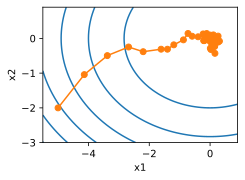

In [2]:
f = lambda x1, x2: x1 ** 2 + 2 * x2 ** 2  # Objective
gradf = lambda x1, x2: (2 * x1, 4 * x2)  # Gradient

def sgd(x1, x2, s1, s2):
    global lr  # Learning rate scheduler
    (g1, g2) = gradf(x1, x2)
    # Simulate noisy gradient
    g1 += torch.normal(0.0, 1, (1,))
    g2 += torch.normal(0.0, 1, (1,))
    eta_t = eta * lr()  # Learning rate at time t
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)  # Update variables

eta = 0.1
lr = (lambda: 1)  # Constant learning rate
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50))

Như có thể thấy, quỹ đạo của các biến trong SGD dao động mạnh hơn hạ gradient ở phần trước. Điều này là do bản chất ngẫu nhiên của gradient. Tức là, ngay cả khi tới gần giá trị cực tiểu, ta vẫn gặp phải sự bất định gây ra bởi gradient ngẫu nhiên  $\eta \nabla f_i(\mathbf{x})$ . Thậm chí sau 50 bước thì chất lượng vẫn không tốt lắm. Tệ hơn, nó vẫn sẽ không cải thiện với nhiều bước hơn (chúng tôi khuyến khích bạn đọc thử nghiệm với số lượng bước lớn hơn để tự xác nhận điều này). Ta chỉ còn một lựa chọn duy nhất — thay đổi tốc độ học  $η$ . Tuy nhiên, nếu chọn giá trị quá nhỏ, ta sẽ không đạt được bất kỳ tiến triển đáng kể nào ở những bước đầu tiên. Mặt khác, nếu chọn giá trị quá lớn, ta sẽ không thu được nghiệm tốt, như đã thấy ở trên. Cách duy nhất để giải quyết hai mục tiêu xung đột này là giảm tốc độ học *một cách linh hoạt* trong quá trình tối ưu.

Đây cũng là lý do cho việc thêm hàm tốc độ học `lr` vào hàm bước `sgd`. Trong ví dụ trên, chức năng định thời tốc độ học (**learning rate scheduling**) không được kích hoạt vì ta đặt hàm `lr` bằng một hằng số, tức `lr = (lambda: 1)`.

### 11.8.2. Tốc độ học Linh hoạt
Thay thế  η  bằng tốc độ học phụ thuộc thời gian  η(t)  sẽ khiến việc kiểm soát sự hội tụ của thuật toán tối ưu trở nên phức tạp hơn. Cụ thể, ta cần tìm ra mức độ suy giảm  η  hợp lý. Nếu giảm quá nhanh, quá trình tối ưu sẽ ngừng quá sớm. Nếu giảm quá chậm, ta sẽ lãng phí rất nhiều thời gian cho việc tối ưu. Có một vài chiến lược cơ bản được sử dụng để điều chỉnh  η  theo thời gian (ta sẽ thảo luận về các chiến lược cao cấp hơn trong chương sau):

\begin{split}\begin{aligned}
    \eta(t) & = \eta_i \text{ if } t_i \leq t \leq t_{i+1}  && \mathrm{hằng~số~theo~khoảng} \\
    \eta(t) & = \eta_0 \cdot e^{-\lambda t} && \mathrm{lũy~thừa} \\
    \eta(t) & = \eta_0 \cdot (\beta t + 1)^{-\alpha} && \mathrm{đa~thức}
\end{aligned}\end{split}
 
Trong trường hợp đầu tiên, ta giảm tốc độ học bất cứ khi nào tiến trình tối ưu bị đình trệ. Đây là một chiến lược phổ biến để huấn luyện các mạng sâu. Ngoài ra, ta có thể làm giảm tốc độ học nhanh hơn bằng suy giảm theo lũy thừa. Thật không may, phương pháp này dẫn đến việc dừng tối ưu quá sớm trước khi thuật toán hội tụ. Một lựa chọn phổ biến khác là suy giảm đa thức với  $α=0.5$ . Trong trường hợp tối ưu lồi, có các chứng minh cho thấy giá trị này cho kết quả tốt. Hãy cùng xem nó hoạt động như thế nào trong thực tế.

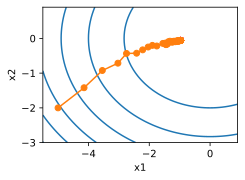

In [3]:
def exponential():
    global ctr
    ctr += 1
    return math.exp(-0.1 * ctr)

ctr = 1
lr = exponential  # Set up learning rate
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=1000))

Như dự đoán, giá trị phương sai của các tham số giảm đáng kể. Tuy nhiên, suy giảm lũy thừa không hội tụ tới nghiệm tối ưu  $x=(0,0)$ . Thậm chí sau 1000 vòng lặp, nghiệm tìm được vẫn cách nghiệm tối ưu rất xa. Trên thực tế, thuật toán này không hội tụ được. Mặt khác, nếu ta sử dụng suy giảm đa thức trong đó tốc độ học suy giảm tỉ lệ nghịch với căn bình phương thời gian, thuật toán hội tụ tốt.

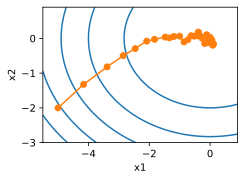

In [4]:
def polynomial():
    global ctr
    ctr += 1
    return (1 + 0.1 * ctr)**(-0.5)

ctr = 1
lr = polynomial  # Set up learning rate
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50))

Vẫn còn có rất nhiều lựa chọn khác để thiết lập tốc độ học. Ví dụ, ta có thể bắt đầu với tốc độ học nhỏ, sau đó tăng nhanh rồi tiếp tục giảm nhưng với tốc độ chậm hơn. Ta cũng có thể thiết lập tốc độ học tăng và giảm luân phiên. Có rất nhiều cách khác nhau để định thời tốc độ học. Bây giờ, chúng ta hãy tập trung vào thiết lập tốc độ học trong điều kiện lồi mà ta có thể phân tích lý thuyết. Với bài toán không lồi tổng quát, rất khó để đảm bảo được mức hội tụ có ý nghĩa, vì nói chung các bài toán tối ưu phi tuyến không lồi đều thuộc dạng NP-hard. Để tìm hiểu thêm, tham khảo các ví dụ trong [tập bài giảng](https://www.stat.cmu.edu/~ryantibs/convexopt-F15/lectures/26-nonconvex.pdf) của Tibshirani năm 2015.

### 11.8.3. Phân tích Hội tụ cho Hàm mục tiêu Lồi
Phần đọc thêm

### 11.8.4. Gradient ngẫu nhiên và Mẫu hữu hạn
Tới phần này, ta đi khá nhanh và chưa chặt chẽ khi thảo luận về hạ gradient ngẫu nhiên. Ta ngầm định lấy các đối tượng  $x_i$ , thường là cùng với nhãn  $y_i$  từ phân phối  $p(x,y)$  nào đó và sử dụng chúng để cập nhật các trọng số  $w$  theo cách nào đó. Cụ thể, với kích thước mẫu hữu hạn, ta đơn giản lập luận rằng phân phối rời rạc  $p(x, y) = \frac{1}{n} \sum_{i=1}^n \delta_{x_i}(x) \delta_{y_i}(y)$  cho phép áp dụng SGD.

Tuy nhiên, đó thật ra không phải là cách ta đã làm. Trong các ví dụ đơn giản ở phần này ta chỉ thêm nhiễu vào gradient không ngẫu nhiên, tức giả sử đang có sẵn các cặp giá trị  $(x_i,y_i)$ . hóa ra cách làm đó khá hợp lý (xem phần bài tập để thảo luận chi tiết). Vấn đề là ở tất cả các thảo luận trước, ta không hề làm thế. Thay vào đó ta duyệt qua tất cả các đối tượng đúng một lần. Để hiểu tại sao quá trình này được ưa chuộng, hãy xét trường hợp ngược lại khi ta lấy có hoàn lại  $N$  mẫu từ một phân phối rời rạc. Xác suất phần tử  $i$  được chọn ngẫu nhiên là  $N−1$ . Do đó xác suất chọn  $i$  ít nhất một lần là

<center>$P(\mathrm{~chọn~} i) = 1 - P(\mathrm{~loại~} i) = 1 - (1-N^{-1})^N \approx 1-e^{-1} \approx 0.63$</center>
 
Tương tự, ta có thể chỉ ra rằng xác suất chọn một mẫu đúng một lần là  ${N \choose 1} N^{-1} (1-N^{-1})^{N-1} = \frac{N-1}{N} (1-N^{-1})^{N} \approx e^{-1} \approx 0.37$ . Điều này gây tăng phương sai và giảm hiệu quả sử dụng dữ liệu so với lấy mẫu không hoàn lại. Do đó trong thực tế, ta thực hiện lấy mẫu không hoàn lại (và đây cũng là lựa chọn mặc định trong quyển sách này). Điều cuối cùng cần chú ý là mỗi lần duyệt lại tập dữ liệu, ta sẽ duyệt theo một thứ tự ngẫu nhiên khác.

### 11.8.5. Tóm tắt
* Đối với các bài toán lồi, ta có thể chứng minh rằng Hạ Gradient Ngẫu nhiên sẽ hội tụ về nghiệm tối ưu với nhiều tốc độ học khác nhau.
* Trường hợp trên thường không xảy ra trong học sâu. Tuy nhiên việc phân tích các bài toán lồi cho ta kiến thức hữu ích để tiếp cận bài toán tối ưu, đó là giảm dần tốc độ học, dù không quá nhanh.
* Nhiều vấn đề xuất hiện khi tốc độ học quá lớn hoặc quá nhỏ. Trong thực tế, ta chỉ có thể tìm được tốc độ học thích hợp sau nhiều lần thử nghiệm.
* Khi kích thước tập huấn luyện tăng, chi phí tính toán cho mỗi lần lặp của hạ gradient cũng tăng theo, do đó SGD được ưa chuộng hơn trong trường hợp này.
* Trong SGD, không có sự đảm bảo tối ưu đối với các trường hợp không lồi do số cực tiểu cần phải kiểm tra có thể tăng theo cấp số nhân.

### 11.8.6. Bài tập
1. Hãy thử nghiệm với nhiều bộ định thời tốc độ học khác nhau trong SGD và với số vòng lặp khác nhau. Cụ thể, hãy vẽ biểu đồ khoảng cách tới nghiệm tối ưu  $(0,0)$  theo số vòng lặp.
2. Chứng minh rằng với hàm  $f(x_1,x_2)=x_1^2+2x_2^2$ , việc thêm nhiễu Gauss (normal noise) vào gradient tương đương với việc cực tiểu hóa hàm mất mát  $l(x,w)=(x_1−w_1)^2+2(x_2−w_2)^2$  trong đó  $x$  tuân theo phân phối chuẩn.
    * Suy ra kỳ vọng và phương sai của  x .
    * Chỉ ra rằng tính chất này có thể áp dụng tổng quát cho hàm mục tiêu  $f(\mathbf{x}) = \frac{1}{2} (\mathbf{x} - \mathbf{\mu})^\top Q (\mathbf{x} - \mathbf{\mu})$  với  $Q⪰0$ .
3. So sánh sự hội tụ của SGD khi lấy mẫu không hoàn lại từ  ${(x_1,y_1),…,(x_m,y_m)}$  và khi lấy mẫu có hoàn lại.
4. Bạn sẽ thay đổi SGD thế nào nếu như một số gradient (hoặc một số toạ độ liên kết với nó) liên tục lớn hơn tất cả các gradient khác?
5. Giả sử  $f(x)=x^2(1+sinx)$ .  f  có bao nhiêu cực tiểu? Thay đổi hàm  $f$  sao cho để cực tiểu hóa giá trị hàm này, ta cần xét tất cả các điểm cực tiểu?

## 11.9. Hạ Gradient Ngẫu nhiên theo Minibatch
Đến giờ, ta đã tiếp xúc với hai thái cực trong các phương pháp học dựa theo gradient: tại mỗi lượt Section 11.7 sử dụng toàn bộ tập dữ liệu để tính gradient và cập nhật tham số. Ngược lại, Section 11.8 xử lý từng điểm dữ liệu một để cập nhật các tham số. Mỗi phương pháp đều có mặt hạn chế riêng. Hạ Gradient có *hiệu suất dữ liệu* (**data efficiency**) thấp khi dữ liệu tương đối giống nhau. Hạ Gradient Ngẫu nhiên có *hiệu suất tính toán* (**computational efficiency**) thấp do CPU và GPU không được khai thác hết khả năng vector hóa. Điều này gợi ý rằng có thể có một phương pháp thích hợp ở giữa, và thực tế, ta đã sử dụng phương pháp đó trong các ví dụ đã thảo luận.

### 11.9.1. Vector hóa và Vùng nhớ đệm
Lý do sử dụng minibatch chủ yếu là vì hiệu suất tính toán. Để dễ hiểu, ta xét trường hợp tính toán song song giữa nhiều GPU và giữa nhiều máy chủ. Trong trường hợp này ta cần đưa ít nhất một ảnh vào mỗi GPU. Với 16 máy chủ và 8 GPU mỗi máy, ta có minibatch kích thước 128.

Vấn đề trở nên nhạy cảm hơn đối với GPU đơn hay ngay cả CPU đơn. Những thiết bị này có nhiều loại bộ nhớ, thường có nhiều loại đơn vị thực hiện tính toán và giới hạn băng thông giữa các đơn vị này cũng khác nhau. Ví dụ, một CPU có số lượng ít thanh ghi, bộ nhớ đệm L1, L2 và trong một số trường hợp có cả L3 (phần bộ nhớ được phân phối giữa các lõi của vi xử lý). Các bộ nhớ đệm đang tăng dần về kích thước và độ trễ (và cùng với đó là giảm băng thông). Nói vậy đủ thấy rằng vi xử lý có khả năng thực hiện nhiều tác vụ hơn so với những gì mà giao diện bộ nhớ chính (**main memory interface**) có thể cung cấp.

* Một CPU tốc độ 2GHz với 16 lõi và phép vector hóa AVX-512 có thể xử lý lên lới  $2⋅109⋅16⋅32=1012$  byte mỗi giây. Khả năng của GPU dễ dàng vượt qua con số này cả trăm lần. Mặt khác, trong vi xử lý của máy chủ cỡ trung bình, băng thông có lẽ không vượt quá 100 GB/s, tức là chưa bằng một phần mười băng thông yêu cầu để đưa dữ liệu vào bộ xử lý. Vấn đề còn tồi tệ hơn khi ta xét đến việc không phải khả năng truy cập bộ nhớ nào cũng như nhau: đầu tiên, giao diện bộ nhớ thường rộng 64 bit hoặc hơn (ví dụ như trên GPU lên đến 384 bit), do đó việc đọc một byte duy nhất vẫn sẽ phải chịu chi phí giống như truy cập một khoảng bộ nhớ rộng hơn.
* Tổng chi phí cho lần truy cập đầu tiên là khá lớn, trong khi truy cập liên tiếp thường hao tổn ít (thường được gọi là đọc hàng loạt). Có rất nhiều điều cần lưu ý, ví dụ như lưu trữ đệm khi ta có nhiều điểm truy cập cuối (**sockets**), nhiều chiplet và các cấu trúc khác. Việc thảo luận chi tiết vấn đề trên nằm ngoài phạm vi của phần này. Bạn có thể tham khảo bài viết [Wikipedia này](https://en.wikipedia.org/wiki/Cache_hierarchy) để hiểu sâu hơn.

Cách để giảm bớt những ràng buộc trên là sử dụng hệ thống cấp bậc (**hierarchy**) của các vùng nhớ đệm trong CPU, các vùng nhớ này đủ nhanh để có thể cung cấp dữ liệu cho vi xử lý. Đây chính là động lực đằng sau việc sử dụng batch trong học sâu. Để đơn giản, xét phép nhân hai ma trận  $\mathbf{A} = \mathbf{B}\mathbf{C}$ . Để tính  $\mathbf{A}$  ta có khá nhiều lựa chọn, ví dụ như:

   1. Ta có thể tính  $\mathbf{A}_{ij} = \mathbf{B}_{i,:} \mathbf{C}_{:,j}^\top$ , tức là tính từng phần tử bằng tích vô hướng.
   2. Ta có thể tính  $\mathbf{A}_{:,j} = \mathbf{B} \mathbf{C}_{:,j}^\top$ , tức là tính theo từng cột. Tương tự, ta có thể tính $\mathbf{A}$  theo từng hàng  $\mathbf{A}_i$.
   3. Ta đơn giản có thể tính  $\mathbf{A} = \mathbf{B}\mathbf{C}$ .
   4. Ta có thể chia  $\mathbf{B}$  và  $\mathbf{C}$  thành nhiều khối ma trận nhỏ hơn và tính  $\mathbf{A}$  theo từng khối một.
   
Nếu sử dụng cách đầu tiên, ta cần sao chép một vector cột và một vector hàng vào CPU cho mỗi lần tính phần tử  $\mathbf{A}_{ij}$ . Tệ hơn nữa, do các phần tử của ma trận được lưu thành một dãy liên tục dưới bộ nhớ, ta buộc phải truy cập nhiều vùng nhớ rời rạc khi đọc một trong hai vector từ bộ nhớ. Cách thứ hai tốt hơn nhiều. Theo cách này, ta có thể giữ vector cột  $\mathbf{C}_{:,j}$  trong vùng nhớ đệm của CPU trong khi ta tiếp tục quét qua  $\mathbf{B}$ . Cách này chỉ cần nửa băng thông cần thiết của bộ nhớ, do đó truy cập nhanh hơn. Đương nhiên cách thứ ba là tốt nhất. Đáng tiếc rằng đa số ma trận quá lớn để có thể đưa vào vùng nhớ đệm (dù sao đây cũng chính là điều ta đang thảo luận). Cách thứ tư là một phương pháp thay thế khá tốt: đưa các khối của ma trận vào vùng nhớ đệm và thực hiện phép nhân cục bộ. Các thư viện đã được tối ưu sẽ thực hiện việc này giúp chúng ta. Hãy xem xét hiệu suất của từng phương pháp trong thực tế.

Ngoài hiệu suất tính toán, chi phí tính toán phát sinh đến từ Python và framework học sâu cũng đáng cân nhắc. Mỗi lần ta thực hiện một câu lệnh, bộ thông dịch Python gửi một câu lệnh đến framework để chèn câu lệnh đó vào đồ thị tính toán và thực thi nó theo đúng lịnh trình. Chi phí đó có thể khá bất lợi. Nói ngắn gọn, nên áp dụng vector hóa (và ma trận) bất cứ khi nào có thể.

In [5]:
%matplotlib inline
from d2l import torch as d2l
import torch
from torch import nn
import numpy as np

timer = d2l.Timer()
A = torch.zeros(256, 256)
B = torch.randn(256, 256)
C = torch.randn(256, 256)

Phép nhân theo từng phần tử chỉ đơn giản là duyệt qua tất cả các hàng và cột của  $\mathbf{B}$  và  $\mathbf{C}$  theo thứ tự rồi gán kết quả cho  $\mathbf{A}$ .

In [6]:
# Compute A = BC one element at a time
timer.start()
for i in range(256):
    for j in range(256):
        A[i, j] = torch.dot(B[i, :], C[:, j])
timer.stop()

1.4483144283294678

Một cách nhanh hơn là nhân theo từng cột.

In [7]:
# Compute A = BC one column at a time
timer.start()
for j in range(256):
    A[:, j] = torch.mv(B, C[:, j])
timer.stop()

0.013002157211303711

Cuối cùng, cách hiệu quả nhất là thực hiện toàn bộ phép nhân trong một khối. Hãy thử xem tốc độ tương ứng của phương pháp này là bao nhiêu.

In [8]:
# Compute A = BC in one go
timer.start()
A = torch.mm(B, C)
timer.stop()

# Multiply and add count as separate operations (fused in practice)
gigaflops = [2/i for i in timer.times]
print(f'performance in Gigaflops: element {gigaflops[0]:.3f}, '
      f'column {gigaflops[1]:.3f}, full {gigaflops[2]:.3f}')

performance in Gigaflops: element 1.381, column 153.821, full 130.040


### 11.9.2. Minibatch
Ở các phần trước ta mặc nhiên đọc dữ liệu theo **minibatch** thay vì từng điểm dữ liệu đơn lẻ để cập nhật các tham số. Ta có thể giải thích ngắn gọn mục đích như sau. Xử lý từng điểm dữ liệu đơn lẻ đòi hỏi phải thực hiện rất nhiều phép nhân ma trận với vector (hay thậm chí vector với vector). Cách này khá tốn kém và đồng thời phải chịu thêm chi phí khá lớn đến từ các framework học sâu bên dưới. Vấn đề này xảy ra ở cả lúc đánh giá một **mạng với dữ liệu mới** (thường gọi là suy luận - **inference**) và khi tính toán gradient để cập nhật các tham số. Tức là vấn đề xảy ra mỗi khi ta thực hiện  $\mathbf{w} \leftarrow \mathbf{w} - \eta_t \mathbf{g}_t$  trong đó

<center>$\mathbf{g}_t = \partial_{\mathbf{w}} f(\mathbf{x}_{t}, \mathbf{w})$</center>
 
Ta có thể tăng hiệu suất tính toán của phép tính này bằng cách áp dụng nó trên mỗi minibatch dữ liệu. Tức là ta thay thế gradient  gt  trên một điểm dữ liệu đơn lẻ bằng gradient trên một batch nhỏ.

<center>$\mathbf{g}_t = \partial_{\mathbf{w}} \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} f(\mathbf{x}_{i}, \mathbf{w})$</center>
 
Hãy thử xem phương pháp trên tác động thế nào đến các tính chất thống kê của  $\mathbf{g}_t$ : do cả  $x_t$  và tất cả các phần tử trong minibatch  $\mathcal{B}_t$  được lấy ra từ tập huấn luyện với xác suất như nhau, kỳ vọng của gradient là không đổi. Mặt khác, phương sai giảm một cách đáng kể. Do gradient của minibatch là trung bình của  $b := |\mathcal{B}_t|$  gradient độc lập, độ lệch chuẩn của nó giảm đi theo hệ số  $b^{-\frac{1}{2}}$ . Đây là một điều tốt, cách cập nhật này có độ tin cậy gần bằng việc lấy gradient trên toàn bộ tập dữ liệu.

Từ ý trên, ta sẽ nhanh chóng cho rằng chọn minibatch  $\mathcal{B}_t$  lớn luôn là tốt nhất. Tiếc rằng đến một mức độ nào đó, độ lệch chuẩn sẽ giảm không đáng kể so với chi phí tính toán tăng tuyến tính. Do đó trong thực tế, ta sẽ chọn kích thước minibatch đủ lớn để hiệu suất tính toán cao trong khi vẫn đủ để đưa vào bộ nhớ của GPU. Để minh hoạ quá trình lưu trữ này, hãy xem đoạn mã nguồn dưới đây. Trong đó ta vẫn thực hiện phép nhân ma trận với ma trận, tuy nhiên lần này ta tách thành từng minibatch 64 cột.

In [9]:
timer.start()
for j in range(0, 256, 64):
    A[:, j:j+64] = torch.mm(B, C[:, j:j+64])
timer.stop()
print(f'performance in Gigaflops: block {2 / timer.times[3]:.3f}')

performance in Gigaflops: block 1006.794


Có thể thấy quá trình tính toán trên minibatch về cơ bản có hiệu suất gần bằng thực hiện trên toàn ma trận. Tuy nhiên, cần lưu ý rằng Trong Section 7.5 ta sử dụng một loại điều chuẩn phụ thuộc chặt chẽ vào phương sai của minibatch. khi tăng kích thước minibatch, phương sai giảm xuống và cùng với đó là lợi ích của việc thêm nhiễu (**noise-injection**) cũng giảm theo do phương pháp chuẩn hóa theo batch. Đọc [Ioffe, 2017] để biết chi tiết cách chuyển đổi giá trị và tính các số hạng phù hợp.

### 11.9.3. Đọc Tập dữ liệu
Hãy xem cách tạo các minibatch từ dữ liệu một cách hiệu quả như thế nào. Trong đoạn mã nguồn dưới ta sử dụng tập dữ liệu được phát triển bởi NASA để kiểm tra [tiếng ồn từ các máy bay](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise) khác nhau để so sánh các thuật toán tối ưu. Để thuận tiện ta chỉ sử dụng  1,500  ví dụ đầu tiên. Tập dữ liệu được tẩy trắng (**whitened**) để xử lý, tức là với mỗi toạ độ ta trừ đi giá trị trung bình và chuyển đổi giá trị phương sai về  1 .

In [10]:
#@save
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                           '76e5be1548fd8222e5074cf0faae75edff8cf93f')

#@save
def get_data_ch11(batch_size=10, n=1500):
    data = np.genfromtxt(d2l.download('airfoil'),
                         dtype=np.float32, delimiter='\t')
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]),
                               batch_size, is_train=True)
    return data_iter, data.shape[1]-1

### 11.9.4. Lập trình từ đầu
Hãy nhớ lại cách lập trình SGD theo minibatch trong Section 3.2. Trong phần tiếp theo, chúng tôi sẽ trình bày cách lập trình tổng quát hơn một chút. Để thuận tiện, hàm lập trình SGD và các thuật toán tối ưu khác được giới thiệu sau trong chương này sẽ có danh sách tham số giống nhau. Cụ thể, chúng ta thêm trạng thái đầu vào `states` và đặt siêu tham số trong từ điển `hyperparams`. Bên cạnh đó, chúng ta sẽ tính giá trị mất mát trung bình của từng minibatch trong hàm huấn luyện, từ đó không cần phải chia gradient cho kích thước batch trong thuật toán tối ưu nữa.

In [11]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data.sub_(hyperparams['lr'] * p.grad)
        p.grad.data.zero_()

Tiếp theo, chúng ta lập trình một hàm huấn luyện tổng quát, sử dụng được cho cả các thuật toán tối ưu khác được giới thiệu sau trong chương này. Hàm sẽ khởi tạo một mô hình hồi quy tuyến tính và có thể được sử dụng để huấn luyện mô hình với SGD theo minibatch và các thuật toán khác.

In [12]:
#@save
def train_ch11(trainer_fn, states, hyperparams, data_iter,
               feature_dim, num_epochs=2):
    # Initialization
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                     requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    # Train
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

Hãy cùng quan sát quá trình tối ưu của thuật toán hạ gradient theo toàn bộ batch. Ta có thể sử dụng toàn bộ batch bằng cách thiết lập kích thước minibatch bằng 1500 (chính là tổng số mẫu). Kết quả là các tham số mô hình chỉ được cập nhật một lần duy nhất trong mỗi epoch. Có thể thấy không có tiến triển đáng kể nào, sau 6 epoch việc tối ưu bị ngừng trệ.

loss: 0.249, 0.044 sec/epoch


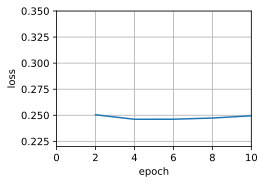

In [13]:
def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = get_data_ch11(batch_size)
    return train_ch11(
        sgd, None, {'lr': lr}, data_iter, feature_dim, num_epochs)

gd_res = train_sgd(1, 1500, 10)

Khi kích thước batch bằng 1, chúng ta sử dụng thuật toán SGD để tối ưu. Để đơn giản hóa việc lập trình, chúng ta cố định tốc độ học bằng một hằng số (có giá trị nhỏ). Trong SGD, các tham số mô hình được cập nhật bất cứ khi nào một mẫu huấn luyện được xử lý. Trong trường hợp này, sẽ có 1500 lần cập nhật trong mỗi epoch. Có thể thấy, sự suy giảm giá trị của hàm mục tiêu chậm lại sau một epoch. Mặc dù cả hai thuật toán cùng xử lý 1500 mẫu trong một epoch, SGD tốn thời gian hơn hạ gradient trong thí nghiệm trên. Điều này là do SGD cập nhật các tham số thường xuyên hơn và kém hiệu quả khi xử lý đơn lẻ từng mẫu.

loss: 0.244, 0.055 sec/epoch


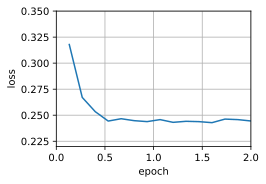

In [14]:
sgd_res = train_sgd(0.005, 1)

Cuối cùng, khi kích thước batch bằng 100, chúng ta sử dụng thuật toán SGD theo minibatch để tối ưu. Thời gian cần thiết cho mỗi epoch ngắn hơn thời gian tương ứng của SGD và hạ gradient theo toàn bộ batch.

loss: 0.244, 0.007 sec/epoch


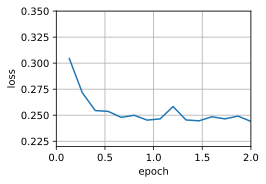

In [15]:
mini1_res = train_sgd(.4, 100)

Giảm kích thước batch bằng 10, thời gian cho mỗi epoch tăng vì thực thi tính toán trên mỗi batch kém hiệu quả hơn.

loss: 0.245, 0.008 sec/epoch


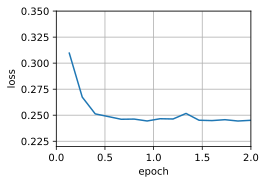

In [16]:
mini2_res = train_sgd(.05, 10)

Cuối cùng, chúng ta so sánh tương quan thời gian và giá trị hàm mất mát trong bốn thí nghiệm trên. Có thể thấy, dù hội tụ nhanh hơn GD về số mẫu được xử lý, nhưng SGD tốn nhiều thời gian hơn để đạt được cùng giá trị mất mát như GD vì thuật toán này tính toán gradient trên từng mẫu một. Thuật toán SGD theo minibatch có thể cân bằng giữa tốc độ hội tụ và hiệu quả tính toán. Với kích thước minibatch bằng 10, thuật toán này hiệu quả hơn SGD; và với kích thước minibatch bằng 100, thời gian chạy của thuật toán này thậm chí nhanh hơn cả GD.

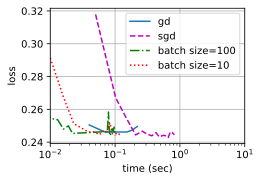

In [17]:
d2l.set_figsize([6, 3])
d2l.plot(*list(map(list, zip(gd_res, sgd_res, mini1_res, mini2_res))),
         'time (sec)', 'loss', xlim=[1e-2, 10],
         legend=['gd', 'sgd', 'batch size=100', 'batch size=10'])
d2l.plt.gca().set_xscale('log')

### 11.9.5. Lập trình Súc tích
Trong Gluon, chúng ta có thể sử dụng lớp `Trainer` để gọi các thuật toán tối ưu. Cách này được sử dụng để có thể lập trình một hàm huấn luyện tổng quát. Chúng ta sẽ sử dụng hàm này xuyên suốt các phần tiếp theo của chương.

In [18]:
#@save
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # Initialization
    net = nn.Sequential(nn.Linear(5, 1))
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)

    loss = nn.MSELoss()
    # Note: L2 Loss = 1/2 * MSE Loss. PyTorch has MSE Loss which is slightly
    # different from MXNet's L2Loss by a factor of 2. Hence we halve the loss
    # value to get L2Loss in PyTorch
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)/2
            l.backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss)/2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')

Lặp lại thí nghiệm với kích thước batch bằng 10 sử dụng Gluon cho kết quả tương tự như trên.

loss: 0.244, 0.008 sec/epoch


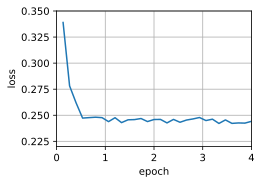

In [19]:
data_iter, _ = get_data_ch11(10)
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.05}, data_iter)

### 11.9.6. Tóm tắt
* Vector hóa tính toán sẽ giúp mã nguồn hiệu quả hơn vì nó giảm chi phí phát sinh từ framework học sâu và tận dụng tính cục bộ của bộ nhớ và vùng nhớ đệm trên CPU và GPU tốt hơn.
* Tồn tại sự đánh đổi giữa hiệu quả về mặt thống kê của SGD và hiệu quả tính toán của việc xử lý các batch dữ liệu kích thước lớn cùng một lúc.
* Thuật toán SGD theo minibatch kết hợp cả hai lợi ích trên: hiệu quả tính toán và thống kê.
* Trong thuật toán đó ta xử lý các batch thu được từ hóan vị ngẫu nhiên của dữ liệu huấn luyện (cụ thể, mỗi mẫu được xử lý chỉ một lần mỗi epoch theo thứ tự ngẫu nhiên).
* Suy giảm tốc độ học trong quá trình huấn luyện được khuyến khích sử dụng.
* Nhìn chung, SGD theo minibatch nhanh hơn SGD và hạ gradient về thời gian hội tụ.

### 11.9.7. Bài tập
1. Sửa đổi kích thước batch và tốc độ học, quan sát tốc độ suy giảm giá trị của hàm mục tiêu và thời gian cho mỗi epoch.
2. Đọc thêm tài liệu MXNet và sử dụng hàm `set_learning_rate` của lớp `Trainer` để giảm tốc độ học của SGD theo minibatch bằng 1/10 giá trị trước đó sau mỗi epoch.
3. Hãy so sánh SGD theo minibatch sử dụng một biến thể *lấy mẫu có hoàn lại* từ tập huấn luyện. Điều gì sẽ xảy ra?
4. Một ác thần đã sao chép tập dữ liệu của bạn mà không nói cho bạn biết (cụ thể, mỗi quan sát bị lặp lại hai lần và kích thước tập dữ liệu tăng gấp đôi so với ban đầu). Cách hoạt động của các thuật toán hạ gradient, SGD và SGD theo minibatch sẽ thay đổi như thế nào?

## 11.10. Động lượng
Trong Section 11.8 chúng ta đã thảo luận cách hoạt động của hạ gradient ngẫu nhiên, chỉ sử dụng một mẫu gradient có nhiễu cho việc tối ưu. Cụ thể, khi có nhiễu ta cần cực kỳ cẩn trọng trong việc chọn tốc độ học. Nếu ta giảm tốc độ học quá nhanh, việc hội tụ sẽ ngưng trệ. Nếu tốc độ học giảm chậm, sẽ khó hội tụ tại một kết quả đủ tốt vì nhiễu sẽ đẩy điểm hội tụ ra xa điểm tối ưu.

### 11.10.1. Kiến thức Cơ bản
Trong phần này, ta sẽ cùng khám phá những thuật toán tối ưu hiệu quả hơn, đặc biệt là cho một số dạng bài toán tối ưu phổ biến trong thực tế.

### 11.10.1.1. Giá trị Trung bình Rò rỉ
Trong phần trước, ta đã thảo luận về hạ gradient ngẫu nhiên theo minibatch như một cách để tăng tốc độ tính toán. Đồng thời, kỹ thuật này cũng có một tác dụng phụ tốt là giúp giảm phương sai.

<center>$\mathbf{g}_{t, t-1} = \partial_{\mathbf{w}} \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} f(\mathbf{x}_{i}, \mathbf{w}_{t-1}) = \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} \mathbf{h}_{i, t-1}$</center>
 
Ở đây để đơn giản kí hiệu, ta đặt $\mathbf{h}_{i, t-1} = \partial_{\mathbf{w}} f(\mathbf{x}_i, \mathbf{w}_{t-1})$  là gradient của mẫu  $i$  với trọng số tại bước thời gian  $t−1$ . Sẽ rất tốt nếu ta có thể tận dụng hơn nữa lợi ích từ việc giảm phương sai, hơn là chỉ lấy trung bình gradient trên minibatch. Một phương pháp để đạt được điều này đó là thay thế việc tính toán gradient bằng một giá trị “trung bình rò rỉ” (**leaky average**):

<center>$\mathbf{v}_t = \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}$</center>
 
với  β∈(0,1) . Phương pháp này thay thế gradient tức thời bằng một giá trị được lấy trung bình trên các gradient trước đó.  v  được gọi là động lượng (momentum). Động lượng tích luỹ các gradient trong quá khứ tương tự như cách một quả bóng nặng lăn xuống ngọn đồi sẽ tích hợp hết tất cả các lực tác động lên nó từ lúc bắt đầu. Để hiểu rõ hơn, hãy khai triển đệ quy  vt  thành

\begin{aligned}
\mathbf{v}_t = \beta^2 \mathbf{v}_{t-2} + \beta \mathbf{g}_{t-1, t-2} + \mathbf{g}_{t, t-1}
= \ldots, = \sum_{\tau = 0}^{t-1} \beta^{\tau} \mathbf{g}_{t-\tau, t-\tau-1}.
\end{aligned}
 
Khi  $β$  lớn đồng nghĩa với việc lấy trung bình trong một khoảng rộng, trong khi đó nếu  $β$  nhỏ phương pháp này sẽ không khác nhiều so với hạ gradient thông thường. Gradient mới này không còn có hướng đi dốc nhất trong từng trường hợp cụ thể nữa mà thay vào đó đi theo hướng trung bình có trọng số của các gradient trước đó. Điều này giúp chúng ta nhận thêm lợi ích của việc tính trung bình theo batch mà không cần tốn chi phí tính toán gradients trên batch. Chúng ta sẽ xem xét cụ thể hơn quy trình lấy trung bình ở những phần sau.

Các lập luận trên là cơ sở để hình thành các phương pháp tăng tốc gradient, chẳng hạn như gradient với động lượng. Một lợi ích phụ là chúng hiệu quả hơn rất nhiều trong các trường hợp bài toán tối ưu có điều kiện xấu (ví dụ: khi một vài hướng có tiến trình tối ưu chậm hơn nhiều so với các hướng khác, giống như ở trong một hẻm núi hẹp). Hơn nữa, cách này cho phép lấy trung bình các gradient liền kề để đạt được hướng đi xuống ổn định hơn. Thật vậy, việc tăng tốc ngay cả đối với bài toán lồi không nhiễu là một trong những nguyên nhân chính lý giải vì sao động lượng hoạt động và có hiệu quả rất tốt.

Do tính hiệu quả của nó, động lượng là một chủ đề đã được nghiên cứu kỹ trong tối ưu hóa cho học sâu và hơn thế nữa. Bài báo rất đẹp này của [Goh, 2017](https://distill.pub/2017/momentum/) cung cấp phân tích chuyên sâu và minh hoạ sinh động về phương pháp động lượng. Động lượng được đề xuất bởi [Polyak, 1964]. [Nesterov, 2018] có một thảo luận chi tiết về lý thuyết động lượng trong ngữ cảnh tối ưu hóa lồi. Động lượng trong học sâu đã được biết đến từ lâu vì lợi ích mà nó mang lại. Tham khảo [Sutskever et al., 2013] để biết thêm chi tiết.

### 11.10.1.2. Bài toán với Điều kiện Xấu
Để hiểu hơn về các tính chất hình học của phương pháp động lượng, hãy ôn lại thuật toán hạ gradient sử dụng hàm mục tiêu khó chịu hơn. Trong Section 11.7 ta sử dụng hàm mục tiêu dạng elip  $f(x)=x_1^2+2x_2^2$ . Ta sẽ sửa hàm này một chút để kéo dãn thêm theo hướng  $x_1$  như sau:

<center>$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2$</center>
 
Cũng như trước,  $f$  đạt cực tiểu tại điểm  $(0,0)$ . Hàm này rất phẳng theo hướng  $x_1$ . Hãy xem điều gì sẽ xảy ra khi thực hiện hạ gradient tương tự như trước trên hàm mới định nghĩa. Ta đặt tốc độ học bằng  $0.4$ .

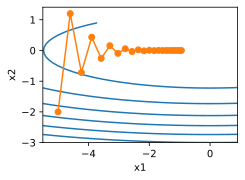

In [1]:
%matplotlib inline
from d2l import torch as d2l
import torch

eta = 0.4
def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2
def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

Có thể thấy gradient theo hướng  $x_2$  có giá trị *lớn hơn nhiều* và thay đổi nhanh hơn nhiều so với gradient theo hướng ngang  $x_1$ . Vì thế, chúng ta bị mắc kẹt giữa hai lựa chọn không mong muốn: Nếu chọn tốc độ học nhỏ, các nghiệm sẽ không phân kỳ theo hướng  $x_2$ , nhưng tốc độ hội tụ sẽ chậm theo hướng  $x_1$ . Ngược lại, với tốc độ học lớn mô hình sẽ hội tụ nhanh theo hướng  $x_1$  nhưng phân kỳ theo hướng  $x_2$ . Ví dụ dưới đây minh họa kết quả khi tăng nhẹ tốc độ học từ  $0.4$  lên  $0.6$ . Sự hội tụ theo hướng  $x_1$  được cải thiện nhưng kết quả cuối cùng tệ hơn rất nhiều.

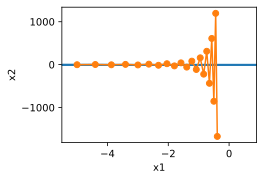

In [2]:
eta = 0.6
d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

### 11.10.1.3. Phương pháp Động lượng
Phương pháp động lượng cho phép chúng ta giải quyết vấn đề với hạ gradient mô tả ở trên. Nhìn vào các vết tối ưu trên, có thể thấy sẽ tốt hơn nếu lấy trung bình gradient trong quá khứ. Ở chiều  $x_1$  các gradient là cùng hướng, cách làm này sẽ đơn thuần lấy tổng độ lớn, từ đó tăng khoảng cách di chuyển ở từng bước. Ngược lại, gradient dao động mạnh theo hướng  $x_2$ , do đó kết hợp các gradient sẽ làm giảm kích thước bước do dao động triệt tiêu lẫn nhau. Sử dụng  $\mathbf{v}_t$  thay vì gradient  $\mathbf{g}_t$ , ta có các phương trình cập nhật sau:

\begin{split}\begin{aligned}
\mathbf{v}_t &\leftarrow \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}, \\
\mathbf{x}_t &\leftarrow \mathbf{x}_{t-1} - \eta_t \mathbf{v}_t.
\end{aligned}\end{split}
 
Với  $β=0$ , phương pháp này tương đương với thuật toán hạ gradient thông thường. Trước khi đi sâu hơn vào các tính chất toán học, hãy xem thuật toán này hoạt động như thế nào.

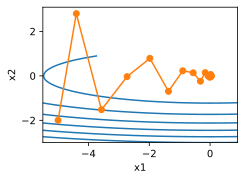

In [3]:
def momentum_2d(x1, x2, v1, v2):
    v1 = beta * v1 + 0.2 * x1
    v2 = beta * v2 + 4 * x2
    return x1 - eta * v1, x2 - eta * v2, v1, v2

eta, beta = 0.6, 0.5
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

Có thể thấy, ngay cả với tốc độ học như trước, phương pháp động lượng vẫn hội tụ tốt. Giờ hãy xem điều gì xảy ra khi giảm tham số động lượng. Giảm một nửa động lượng  $β=0.25$  dẫn đến một quỹ đạo chưa thật sự hội tụ. Tuy nhiên, kết quả đó vẫn tốt hơn rất nhiều so với khi không sử dụng động lượng (nghiệm phân kỳ).

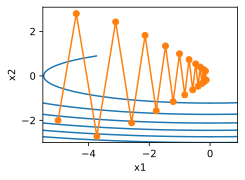

In [4]:
eta, beta = 0.6, 0.25
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

Ta cũng có thể kết hợp động lượng với SGD và đặc biệt là SGD theo minibatch. Thay đổi duy nhất trong trường hợp đó là các gradient  $\mathbf{g}_{t, t-1}$  được thay bằng  $\mathbf{g}_t$ . Cuối cùng, để thuận tiện ta khởi tạo  $\mathbf{v}_0=0$  tại thời điểm  $t=0$ . Hãy xem phép trung bình rò rỉ thực sự làm gì khi cập nhật.

### 11.10.1.4. Trọng số mẫu hiệu dụng
Hãy nhớ lại rằng  $\mathbf{v}_t = \sum_{\tau = 0}^{t-1} \beta^{\tau} \mathbf{g}_{t-\tau, t-\tau-1}$ . Tại giới hạn, tổng các số hạng là  $\sum_{\tau=0}^\infty \beta^\tau = \frac{1}{1-\beta}$ . Nói cách khác, thay vì kích thước bước  $η$  trong GD hoặc SGD, ta thực hiện bước dài hơn  $\frac{\eta}{1-\beta}$ , đồng thời hướng giảm gradient nhiều khả năng cũng tốt hơn. Đây là hai lợi ích trong một. Để minh họa ảnh hưởng của trọng số với các giá trị  $β$  khác nhau, hãy xem minh họa dưới đây.

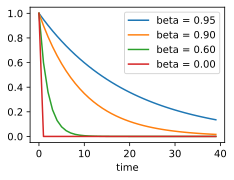

In [5]:
d2l.set_figsize()
betas = [0.95, 0.9, 0.6, 0]
for beta in betas:
    x = d2l.numpy(torch.arange(40))
    d2l.plt.plot(x, beta ** x, label=f'beta = {beta:.2f}')
d2l.plt.xlabel('time')
d2l.plt.legend();

### 11.10.2. Thực nghiệm
Hãy xem động lượng hoạt động như thế nào trong thực tế, khi được sử dụng cùng một bộ tối ưu. Để làm điều này, ta cần các đoạn mã dễ mở rộng hơn.

### 11.10.2.1. Lập trình từ đầu
So với SGD hoặc SGD theo minibatch, phương pháp động lượng cần duy trì các biến phụ trợ, chính là vận tốc. Nó có kích thước giống gradient (và các biến khác trong bài toán tối ưu). Trong đoạn mã bên dưới, ta gọi các biến vận tốc này là `states`.

In [6]:
def init_momentum_states(feature_dim):
    v_w = torch.zeros((feature_dim, 1))
    v_b = torch.zeros(1)
    return (v_w, v_b)

def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        with torch.no_grad():
            v[:] = hyperparams['momentum'] * v + p.grad
            p[:] -= hyperparams['lr'] * v
        p.grad.data.zero_()

Hãy xem đoạn mã hoạt động như thế nào trong thực tế.

loss: 0.244, 0.020 sec/epoch


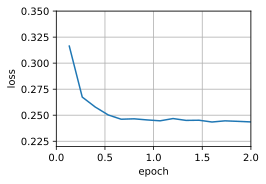

In [7]:
def train_momentum(lr, momentum, num_epochs=2):
    d2l.train_ch11(sgd_momentum, init_momentum_states(feature_dim),
                   {'lr': lr, 'momentum': momentum}, data_iter,
                   feature_dim, num_epochs)

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
train_momentum(0.02, 0.5)

Khi tăng siêu tham số động lượng `momentum` lên 0.9, kích thước mẫu hiệu dụng sẽ tăng lên đáng kể thành $\frac{1}{1 - 0.9} = 10$ . Ta giảm tốc độ học xuống còn  $0.01$  để kiểm soát vấn đề.

loss: 0.250, 0.013 sec/epoch


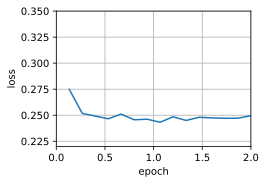

In [8]:
train_momentum(0.01, 0.9)

Tiếp tục giảm tốc độ học sẽ giải quyết bất kỳ vấn đề tối ưu không trơn tru nào. Giảm còn  $0.005$  đem lại các đặc tính hội tụ tốt.

loss: 0.243, 0.012 sec/epoch


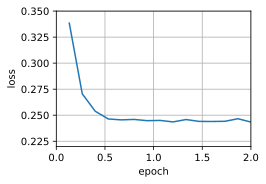

In [9]:
train_momentum(0.005, 0.9)

### 11.10.2.2. Lập trình Súc tích
Rất đơn giản nếu sử dụng Gluon vì bộ tối ưu sgd tiêu chuẩn đã tích hợp sẵn phương pháp động lượng. Với cùng các tham số, ta có quỹ đạo rất giống khi lập trình từ đầu.

loss: 0.247, 0.012 sec/epoch


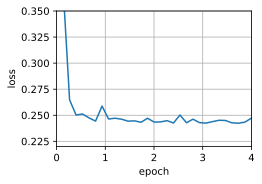

In [10]:
trainer = torch.optim.SGD
d2l.train_concise_ch11(trainer, {'lr': 0.005, 'momentum': 0.9}, data_iter)

### 11.10.3. Phân tích Lý thuyết
Cho đến nay, ví dụ hai chiều  $f(x)=0.1x_1^2+2x_2^2$  dường như không thực tế cho lắm. Thực tế, hàm này khá tiêu biểu cho các dạng bài toán có thể gặp phải, ít nhất trong trường hợp cực tiểu hóa các hàm mục tiêu lồi bậc hai.

### 11.10.3.1. Hàm lồi bậc Hai
Xét hàm số

<center>$h(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{x}^\top \mathbf{c} + b$</center>
 
Đây là một hàm bậc hai tổng quát. Với ma trận xác định dương  $\mathbf{Q} \succ 0$ , tức ma trận có trị riêng dương, hàm có nghiệm cực tiểu tại  $\mathbf{x}^* = -\mathbf{Q}^{-1} \mathbf{c}$  với giá trị cực tiểu  $b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}$ . Do đó ta có thể viết lại  $h$  như sau

<center>$h(\mathbf{x}) = \frac{1}{2} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})^\top \mathbf{Q} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c}) + b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}$</center>
 
Gradient được tính bởi  $\partial_{\mathbf{x}} f(\mathbf{x}) = \mathbf{Q} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})$ . Nghĩa là bằng khoảng cách giữa  x  và nghiệm cực tiểu nhân với  $\mathbf{Q}$ . Do đó, động lượng cũng là tổ hợp tuyến tính của  $\mathbf{Q} (\mathbf{x}_t - \mathbf{Q}^{-1} \mathbf{c})$ .

Vì  $\mathbf{Q}$  là xác định dương nên nó có thể được phân tích thành hệ riêng thông qua  $\mathbf{Q} = \mathbf{O}^\top \boldsymbol{\Lambda} \mathbf{O}$ , với  $\mathbf{O}$  là ma trận trực giao (xoay vòng) và  $\boldsymbol{\Lambda}$  là ma trận đường chéo của các trị riêng dương. Điều này cho phép ta đổi biến  $\mathbf{x}$  thành  $\mathbf{z} := \mathbf{O} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})$  để có biểu thức đơn giản hơn nhiều:

<center>$h(\mathbf{z}) = \frac{1}{2} \mathbf{z}^\top \boldsymbol{\Lambda} \mathbf{z} + b'$</center>
 
Ở đây  $c' = b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}$ . Vì  $\mathbf{O}$  chỉ là một ma trận trực giao nên điều này không làm nhiễu các gradient một cách có ý nghĩa. Biểu diễn theo  $\mathbf{z}$ , ta có hạ gradient

<center>$\mathbf{z}_t = \mathbf{z}_{t-1} - \boldsymbol{\Lambda} \mathbf{z}_{t-1} = (\mathbf{I} - \boldsymbol{\Lambda}) \mathbf{z}_{t-1}$</center>
 
Một điểm quan trọng trong biểu thức này là hạ gradient không trộn lẫn các không gian riêng khác nhau. Nghĩa là, khi được biểu diễn dưới dạng hệ riêng của  $\mathbf{Q}$ , việc tối ưu được thực hiện theo từng trục tọa độ. Điều này cũng đúng với phương pháp động lượng.

\begin{split}\begin{aligned}
\mathbf{v}_t & = \beta \mathbf{v}_{t-1} + \boldsymbol{\Lambda} \mathbf{z}_{t-1} \\
\mathbf{z}_t & = \mathbf{z}_{t-1} - \eta \left(\beta \mathbf{v}_{t-1} + \boldsymbol{\Lambda} \mathbf{z}_{t-1}\right) \\
    & = (\mathbf{I} - \eta \boldsymbol{\Lambda}) \mathbf{z}_{t-1} - \eta \beta \mathbf{v}_{t-1}.
\end{aligned}\end{split}
 
Khi thực hiện điều này, ta đã chứng minh định lý sau: Hạ Gradient có và không có động lượng cho hàm lồi bậc hai có thể được phân tích thành bài toán tối ưu theo hướng các vector riêng của ma trận bậc hai theo từng trục tọa độ.

### 11.10.3.2. Hàm vô hướng
Với kết quả trên hãy xem điều gì xảy ra khi cực tiểu hóa hàm  $f(x) = \frac{\lambda}{2} x^2$ . Ta có hạ gradient

$x_{t+1} = x_t - \eta \lambda x_t = (1 - \eta \lambda) x_t.$
 
Với $|1 - \eta \lambda| < 1$ , sau  $t$  bước ta có  $x_t = (1 - \eta \lambda)^t x_0$ , do đó tốc độ hội tụ sẽ theo hàm mũ. Tốc độ hội tụ sẽ tăng khi tăng tốc độ học  $η$  cho đến khi  $\eta \lambda = 1$ . Khi  $\eta \lambda >2$ , bài toán tối ưu sẽ phân kỳ.

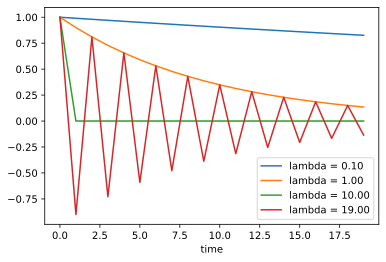

In [11]:
lambdas = [0.1, 1, 10, 19]
eta = 0.1
d2l.set_figsize((6, 4))
for lam in lambdas:
    t = d2l.numpy(torch.arange(20))
    d2l.plt.plot(t, (1 - eta * lam) ** t, label=f'lambda = {lam:.2f}')
d2l.plt.xlabel('time')
d2l.plt.legend();

Để phân tích tính hội tụ khi sử dụng động lượng, ta viết lại các phương trình cập nhật theo hai số vô hướng:  $x$  và động lượng  $v$ . Ta có:

\begin{split}\begin{bmatrix} v_{t+1} \\ x_{t+1} \end{bmatrix} =
\begin{bmatrix} \beta & \lambda \\ -\eta \beta & (1 - \eta \lambda) \end{bmatrix}
\begin{bmatrix} v_{t} \\ x_{t} \end{bmatrix} = \mathbf{R}(\beta, \eta, \lambda) \begin{bmatrix} v_{t} \\ x_{t} \end{bmatrix}.\end{split}
 
Ta kí hiệu  $\mathbf{R}$  là ma trận chi phối hội tụ, kích thước  $2×2$ . Sau  $t$  bước thì giá trị ban đầu  $[v_0, x_0]$  sẽ là  $\mathbf{R}(\ beta, \eta, \lambda)^t [v_0, x_0]$ . Do đó, các trị riêng của  $\mathbf{R}$  sẽ quyết định tốc độ hội tụ. Độc giả có thể xem hình ảnh động tại bài viết của Distill của [Goh, 2017] và đọc thêm [Flammarion & Bach, 2015] để biết phân tích chi tiết. Có thể chỉ ra rằng phương pháp động lượng hội tụ với  $0 < \eta \lambda <2$ , có khoảng tham số khả thi lớn hơn khoảng  $0<ηλ<2$  của hạ gradient. Điều này cũng gợi ý rằng nhìn chung ta mong muốn  $β$  có giá trị lớn. Chi tiết kỹ thuật đòi hỏi nền tảng kiến thức sâu hơn, bạn đọc quan tâm có thể tham khảo các bài báo gốc.

### 11.10.4. Tóm tắt
* Phương pháp động lượng thay thế gradient bằng trung bình rò rỉ của các gradient trong quá khứ, giúp tăng tốc độ hội tụ đáng kể.
* Phương pháp này có thể sử dụng cho cả hạ gradient không nhiễu và hạ gradient ngẫu nhiên (có nhiễu).
* * Phương pháp động lượng giúp tránh việc tối ưu bị ngưng trệ, điều nhiều khả năng xảy ra đối với hạ gradient ngẫu nhiên.
* Số lượng gradient hiệu dụng là  $\frac{1}{1-\beta}$ , được tính bằng giới hạn của tổng cấp số nhân.
* Trong trường hợp các bài toán lồi bậc hai, hạ gradient (có và không có động lượng) có thể được phân tích chi tiết một cách tường minh.
* Việc lập trình khá đơn giản nhưng cần lưu trữ thêm một vector trạng thái (động lượng  $v$ ).

### 11.10.5. Bài tập
1. Quan sát và phân tích kết quả khi sử dụng các tổ hợp động lượng và tốc độ học khác nhau.
2. Hãy thử dùng hạ gradient có động lượng cho bài toán bậc hai có nhiều trị riêng, ví dụ:  $f(x) = \frac{1}{2} \sum_i \lambda_i x_i^2$ , e.g.,  $\lambda_i = 2^{-i}$ . Vẽ đồ thị biểu diễn sự giảm của  $x$  khi khởi tạo  $x_i=1$ .
3. Tính giá trị và nghiệm cực tiểu của  $h(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{x}^\top \mathbf{c} + b$ .
4. Điều gì thay đổi khi ta thực hiện SGD và SGD theo minibatch có động lượng? Thử nghiệm với các tham số.

## 11.11. Adagrad
Để khởi động, hãy cùng xem xét các bài toán với những đặc trưng xuất hiện không thường xuyên.

### 11.11.1. Đặc trưng Thưa và Tốc độ Học
Hãy tưởng tượng ta đang huấn luyện một mô hình ngôn ngữ. Để đạt độ chính xác cao ta thường muốn giảm dần tốc độ học trong quá trình huấn luyện, thường là với tỉ lệ  $\mathcal{O}(t^{-\frac{1}{2}})$  hoặc chậm hơn. Xét một mô hình huấn luyện dựa trên những đặc trưng thưa, tức là các đặc trưng hiếm khi xuất hiện. Đây là điều thường gặp trong ngôn ngữ tự nhiên, ví dụ từ **preconditioning** hiếm gặp hơn nhiều so với **learning**. Tuy nhiên, đây cũng là vấn đề thường gặp trong nhiều mảng khác như *quảng cáo điện toán* (**computational advertising**) và *lọc cộng tác* (**collaborative filtering**). Xét cho cùng, có rất nhiều thứ mà chỉ có một nhóm nhỏ người chú ý đến.

Các tham số liên quan đến các đặc trưng thưa chỉ được cập nhật khi những đặc trưng này xuất hiện. Đối với tốc độ học giảm dần, ta có thể gặp phải trường hợp các tham số của những đặc trưng phổ biến hội tụ khá nhanh đến giá trị tối ưu, trong khi đối với các đặc trưng thưa, ta không có đủ số lượng dữ liệu thích đáng để xác định giá trị tối ưu của chúng. Nói một cách khác, tốc độ học hoặc là giảm quá chậm đối với các đặc trưng phổ biến hoặc là quá nhanh đối với các đặc trưng hiếm.

Một mẹo để khắc phục vấn đề này là đếm số lần ta gặp một đặc trưng nhất định và sử dụng nó để điều chỉnh tốc độ học. Tức là thay vì chọn tốc độ học theo công thức  $\eta = \frac{\eta_0}{\sqrt{t + c}}$  ta có thể sử dụng  $\eta_i = \frac{\eta_0}{\sqrt{s(i, t) + c}}$ . Trong đó  $s(i, t)$  là số giá trị khác không của đặc trưng  $i$  ta quan sát được đến thời điểm  $t$ . Công thức này khá dễ để lập trình và không tốn thêm bao nhiêu công sức. Tuy nhiên, cách này thất bại trong trường hợp khi đặc trưng không hẳn là thưa, chỉ là có gradient nhỏ và hiếm khi đạt giá trị lớn. Xét cho cùng, ta khó có thể phân định rõ ràng khi nào thì một đặc trưng là đã được quan sát hay chưa.

Adagrad được đề xuất trong [Duchi et al., 2011](https://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf) đã giải quyết vấn đề này bằng cách thay đổi bộ đếm thô  $s(i,t)$  bởi tổng bình phương của tất cả các gradient được quan sát trước đó. Cụ thể, nó sử dụng  $s(i, t+1) = s(i, t) + \left(\partial_i f(\mathbf{x})\right)^2$  làm công cụ để điều chỉnh tốc độ học. Việc này đem lại hai lợi ích: trước tiên ta không cần phải quyết định khi nào thì gradient được coi là đủ lớn. Thứ hai, nó tự động thay đổi giá trị tuỳ theo độ lớn của gradient. Các tọa độ thường xuyên có gradient lớn bị giảm đi đáng kể, trong khi các tọa độ khác với gradient nhỏ được xử lý nhẹ nhàng hơn nhiều. Phương pháp này trong thực tế đưa ra một quy trình tối ưu hoạt động rất hiệu quả trong quảng cáo điện toán và các bài toán liên quan. Tuy nhiên, Adagrad vẫn còn ẩn chứa một vài lợi ích khác mà ta sẽ hiểu rõ nhất khi xét đến bối cảnh tiền điều kiện.

### 11.11.2. Tiền điều kiện
Các bài toán tối ưu lồi rất phù hợp để phân tích đặc tính của các thuật toán. Suy cho cùng, với đa số các bài toán không lồi ta khó có thể tìm được các chứng minh lý thuyết vững chắc. Tuy nhiên, trực giác và ý nghĩa hàm chứa suy ra từ các bài toán tối ưu lồi vẫn có thể được áp dụng. Xét bài toán cực tiểu hóa  $f(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{c}^\top \mathbf{x} + b$ .

Như ta đã thấy ở Section 11.10, ta có thể biến đổi bài toán sử dụng phép phân tích trị riêng  $\mathbf{Q} = \mathbf{U}^\top \boldsymbol{\Lambda} \mathbf{U}$  nhằm biến đổi nó về dạng đơn giản hơn mà ta có thể xử lý trên từng tọa độ một:

<center>$f(\mathbf{x}) = \bar{f}(\bar{\mathbf{x}}) = \frac{1}{2} \bar{\mathbf{x}}^\top \boldsymbol{\Lambda} \bar{\mathbf{x}} + \bar{\mathbf{c}}^\top \bar{\mathbf{x}} + b.$</center>
 
Ở đây ta sử dụng  $\mathbf{x} = \mathbf{U} \mathbf{x}$  và theo đó  $\mathbf{c} = \mathbf{U} \mathbf{c}$ . Bài toán sau khi được biến đổi có các nghiệm cực tiểu (minimizer)  $\bar{\mathbf{x}} = -\boldsymbol{\Lambda}^{-1} \bar{\mathbf{c}}$  và giá trị nhỏ nhất $-\frac{1}{2} \bar{\mathbf{c}}^\top \boldsymbol{\Lambda}^{-1} \bar{\mathbf{c}} + b$ . Việc tính toán trở nên dễ dàng hơn nhiều do  $\boldsymbol{\Lambda}$  là một ma trận đường chéo chứa các trị riêng của  $\mathbf{Q}$ .

Nếu ta làm nhiễu  $\mathbf{c}$  một chút, ta sẽ mong rằng các nghiệm cực tiểu của  $f$  cũng chỉ thay đổi không đáng kể. Đáng tiếc thay, điều đó lại không xảy ra. Mặc dù thay đổi  $\mathbf{c}$  một chút dẫn đến  $\bar{\mathbf{c}}$  cũng thay đổi một lượng tương ứng, các nghiệm cực tiểu của  $f$  (cũng như  $\bar{f}$ ) lại không như vậy. Mỗi khi các trị riêng  $\boldsymbol{\Lambda}_i$  mang giá trị lớn, ta sẽ thấy  $\bar{x}_i$  và cực tiểu của  $f$  thay đổi khá nhỏ. Ngược lại, với  $\boldsymbol{\Lambda}_i$  nhỏ, sự thay đổi  $\bar{x}_i$  có thể là đáng kể. Tỉ lệ giữa trị riêng lớn nhất và nhỏ nhất được gọi là hệ số điều kiện (condition number) của bài toán tối ưu.

<center>$\kappa = \frac{\boldsymbol{\Lambda}_1}{\boldsymbol{\Lambda}_d}$</center>
 
Nếu hệ số điều kiện  $\kappa$  lớn, việc giải bài toán tối ưu một cách chính xác trở nên khá khó khăn. Ta cần đảm bảo việc lựa chọn một khoảng động lớn các giá trị phù hợp. Quá trình phân tích dẫn đến một câu hỏi hiển nhiên dù có phần ngây thơ rằng: chẳng phải ta có thể “sửa chữa” bài toán bằng cách biến đổi không gian sao cho tất cả các trị riêng đều có giá trị bằng  $1$ . Điều này khá đơn giản trên lý thuyết: ta chỉ cần tính các trị riêng và các vector riêng của  $\mathbf{Q}$  nhằm biến đổi bài toán từ  $\mathbf{x}$  sang  $\mathbf{z} := \boldsymbol{\Lambda}^{\frac{1}{2}} \mathbf{U} \mathbf{x}$ . Trong hệ toạ độ mới,  $\mathbf{x}^\top \mathbf{Q} \mathbf{x}$  có thể được đơn giản hóa thành  $\|\mathbf{z}\|^2$ . Nhưng có vẻ hướng giải quyết này không thực tế. Việc tính toán các trị riêng và các vector riêng thường tốn kém hơn rất nhiều so với việc tìm lời giải cho bài toán thực tế.

Trong khi việc tính toán chính xác các trị riêng có thể có chi phí cao, việc ước chừng và tính toán xấp xỉ chúng đã là tốt hơn nhiều so với không làm gì cả. Trong thực tế, ta có thể sử dụng các phần tử trên đường chéo của  $\mathbf{Q}$  và tái tỉ lệ chúng một cách tương ứng. Việc này có chi phí tính toán thấp hơn nhiều so với tính các trị riêng.

<center>$\tilde{\mathbf{Q}} = \mathrm{diag}^{-\frac{1}{2}}(\mathbf{Q}) \mathbf{Q} \mathrm{diag}^{-\frac{1}{2}}(\mathbf{Q})$</center>
 
Trong trường hợp này ta có  $\tilde{\mathbf{Q}}_{ij} = \mathbf{Q}_{ij} / \sqrt{\mathbf{Q}_{ii} \mathbf{Q}_{jj}}$  và cụ thể  $\tilde{\mathbf{Q}}_{ii} = 1$  với mọi  $i$ . Trong đa số các trường hợp, cách làm này sẽ đơn giản hóa đáng kể hệ số điều kiện. Ví dụ đối với các trường hợp ta đã thảo luận ở phần trước, việc này sẽ triệt tiêu hoàn toàn vấn đề đang có do các bài toán đều có cấu trúc hình học với các cạnh song song trục toạ độ (axis aligned).

Đáng tiếc rằng ta phải tiếp tục đối mặt với một vấn đề khác: trong học sâu, ta thường không tính được ngay cả đạo hàm bậc hai của hàm mục tiêu. Đối với  $\mathbf{x} \in \mathbb{R}^d$ , đạo hàm bậc hai thậm chí với một minibatch có thể yêu cầu không gian và độ phức tạp lên đến  $\mathcal{O}(d^2)$  để tính toán, do đó khiến cho vấn đề không thể thực hiện được trong thực tế. Sự khéo léo của Adagrad nằm ở việc sử dụng một biến đại diện (proxy) để tính toán đường chéo của ma trận Hessian một cách hiệu quả và đơn giản—đó là độ lớn của chính gradient.

Để tìm hiểu tại sao cách này lại có hiệu quả, hãy cùng xét $\bar{f}(\bar{\mathbf{x}})$ . Ta có:

<center>$\partial_{\bar{\mathbf{x}}} \bar{f}(\bar{\mathbf{x}}) = \boldsymbol{\Lambda} \bar{\mathbf{x}} + \bar{\mathbf{c}} = \boldsymbol{\Lambda} \left(\bar{\mathbf{x}} - \bar{\mathbf{x}}_0\right)$</center>
 
trong đó  $\bar{\mathbf{x}}_0$  là nghiệm cực tiểu của  $\bar{f}$ . Do đó độ lớn của gradient phụ thuộc vào cả  $\boldsymbol{\Lambda}$  và khoảng cách đến điểm tối ưu. Nếu  $\bar{\mathbf{x}} - \bar{\mathbf{x}}_0$  không đổi thì đây chính là tất cả các giá trị ta cần tính. Suy cho cùng, trong trường hợp này độ lớn của gradient  $\partial_{\bar{\mathbf{x}}} \bar{f}(\bar{\mathbf{x}})$  là đủ. Do AdaGrad là một thuật toán hạ gradient ngẫu nhiên, ta sẽ thấy các gradient có phương sai khác không ngay cả tại điểm tối ưu. Chính vì thế ta có thể yên tâm sử dụng phương sai của các gradient như một biến đại diện dễ tính cho độ lớn của ma trận Hessian. Việc phân tích chi tiết nằm ngoài phạm vi của phần này (có thể lên đến nhiều trang). Độc giả có thể tham khảo [Duchi et al., 2011] để biết thêm chi tiết.

### 11.11.3. Thuật toán
Hãy cùng công thức hóa phần thảo luận ở trên. Ta sử dụng biến  st  để tích luỹ phương sai của các gradient trong quá khứ như sau:

\begin{split}\begin{aligned}
    \mathbf{g}_t & = \partial_{\mathbf{w}} l(y_t, f(\mathbf{x}_t, \mathbf{w})), \\
    \mathbf{s}_t & = \mathbf{s}_{t-1} + \mathbf{g}_t^2, \\
    \mathbf{w}_t & = \mathbf{w}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \cdot \mathbf{g}_t.
\end{aligned}\end{split}
 
Ở đây các phép toán được thực hiện theo từng tọa độ. Nghĩa là,  $\mathbf{v}^2$  có các phần tử $v_i^2$ . Tương tự,  $\frac{1}{\sqrt{v}}$  cũng có các phần tử  $\frac{1}{\sqrt{v_i}}$  và  $\mathbf{u} \cdot \mathbf{v}$  có các phần tử  $u_i v_i$ . Như phần trước  $\eta$  là tốc độ học và  $ϵ$  là hằng số cộng thêm đảm bảo rằng ta không bị lỗi chia cho  $0$ . Cuối cùng, ta khởi tạo  $\mathbf{s}_0 = \mathbf{0}$ .

Tương tự như trường hợp sử dụng động lượng, ta cần phải theo dõi các biến bổ trợ để mỗi toạ độ có một tốc độ học độc lập. Cách này không làm tăng chi phí của Adagrad so với SGD, lý do đơn giản là bởi chi phí chính yếu thường nằm ở bước tính  $l(y_t, f(\mathbf{x}_t, \mathbf{w}))$  và đạo hàm của nó.

Cần lưu ý, tổng bình phương các gradient trong $\mathbf{s}_t$  có thể hiểu là về cơ bản $\mathbf{s}_t$  tăng một cách tuyến tính (có phần chậm hơn so với tuyến tính trong thực tế, do gradient lúc ban đầu bị co lại). Điều này dẫn đến tốc độ học là  $\mathcal{O}(t^{-\frac{1}{2}})$ , mặc dù được điều chỉnh theo từng toạ độ một. Đối với các bài toán lồi, như vậy là hoàn toàn đủ. Tuy nhiên trong học sâu, có lẽ ta sẽ muốn giảm tốc độ học chậm hơn một chút. Việc này dẫn đến một số biến thể của Adagrad mà ta sẽ thảo luận trong các phần tới. Còn bây giờ hãy cùng xét cách thức hoạt động của Adagrad trong một bài toán lồi bậc hai. Ta vẫn giữ nguyên bài toán như cũ:

$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2.$
 
Ta sẽ lập trình Adagrad với tốc độ học giữ nguyên như phần trước, tức  $η=0.4$ . Có thể thấy quỹ đạo của biến độc lập mượt hơn nhiều. Tuy nhiên, do ta tính tổng  $\boldsymbol{s}_t$ , tốc độ học liên tục suy giảm khiến cho các biến độc lập không thay đổi nhiều ở các giai đoạn về sau của vòng lặp.

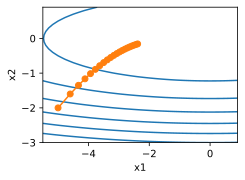

In [1]:
%matplotlib inline
from d2l import torch as d2l
import math
import torch

def adagrad_2d(x1, x2, s1, s2):
    eps = 1e-6
    g1, g2 = 0.2 * x1, 4 * x2
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

Nếu tăng tốc độ học lên  2 , ta có thể thấy quá trình học tốt hơn đáng kể. Điều này chứng tỏ rằng tốc độ học giảm khá mạnh, ngay cả trong trường hợp không có nhiễu và ta cần phải đảm bảo rằng các tham số hội tụ một cách thích hợp.

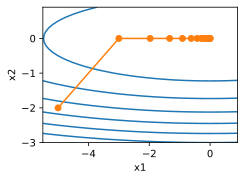

In [2]:
eta = 2
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

### 11.11.4. Lập trình từ đầu
Giống như phương pháp động lượng, **Adagrad** cần duy trì một biến trạng thái có cùng kích thước với các tham số.

In [4]:
def init_adagrad_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] += torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

Ta sử dụng tốc độ học lớn hơn so với thí nghiệm ở Section 11.9 để huấn luyện mô hình.

loss: 0.243, 0.014 sec/epoch


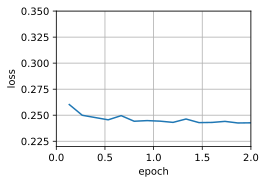

In [5]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adagrad, init_adagrad_states(feature_dim),
               {'lr': 0.1}, data_iter, feature_dim);

### 11.11.5. Lập trình Súc tích
Sử dụng đối tượng Trainer trong thuật toán adagrad, ta có thể gọi thuật toán Adagrad trong Gluon.

loss: 0.243, 0.013 sec/epoch


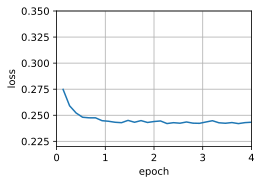

In [6]:
trainer = torch.optim.Adagrad
d2l.train_concise_ch11(trainer, {'lr': 0.1}, data_iter)

### 11.11.6. Tóm tắt
* Adagrad liên tục giảm giá trị của tốc độ học theo từng toạ độ.
* Thuật toán sử dụng độ lớn của gradient như một phương thức để điều chỉnh tiến độ học - các tọa độ với gradient lớn được cân bằng bởi tốc độ học nhỏ.
* Tính đạo hàm bậc hai một cách chính xác thường không khả thi trong các bài toán học sâu do hạn chế về bộ nhớ và khả năng tính toán. Do đó, gradient có thể trở thành một biến đại diện hữu ích.
* Nếu bài toán tối ưu có cấu trúc không được đồng đều, Adagrad có thể làm giảm bớt sự biến dạng đó.
* Adagrad thường khá hiệu quả đối với các đặc trưng thưa, trong đó tốc độ học cần giảm chậm hơn cho các tham số hiếm khi xảy ra.
* Trong các bài toán học sâu, Adagrad đôi khi làm giảm tốc độ học quá mạnh. Ta sẽ thảo luận các chiến lược nhằm giảm bớt vấn đề này trong ngữ cảnh của Section 11.14.

### 11.11.7. Bài tập
1. Chứng minh rằng một ma trận trực giao $\mathbf{U}$  và một vector  $\mathbf{c}$  thoả mãn điều kiện: $\|\mathbf{c} - \mathbf{\delta}\|_2 = \|\mathbf{U} \mathbf{c} - \mathbf{U} \mathbf{\delta}\|_2$ . Tại sao biểu thức trên lại biểu thị rằng độ nhiễu loạn không thay đổi khi biến đổi trực giao các biến?
2. Thử áp dụng Adagrad đối với  $f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2$  và đối với hàm mục tiêu được quay 45 độ, tức là  $f(\mathbf{x}) = 0.1 (x_1 + x_2)^2 + 2 (x_1 - x_2)^2$ . Adagrad có hoạt động khác đi hay không?
3. Chứng minh Định lý Gerschgorin, định lý phát biểu rằng với các trị riêng  $\lambda_i$  của ma trận  $\mathbf{M}$ , tồn tại  $j$  thoả mãn  $|\lambda_i - \mathbf{M}_{jj}| \leq \sum_{k \neq j} |\mathbf{M}_{jk}|$.
4. Từ định lý Gerschgorin, ta có thể chỉ ra điều gì về các trị riêng của ma trận đường chéo tiền điều kiện (**diagonally preconditioned matrix**)  $\mathrm{diag}^{-\frac{1}{2}}(\mathbf{M}) \mathbf{M} \mathrm{diag}^{-\frac{1}{2}}(\mathbf{M})$ ?
5. Hãy thử áp dụng Adagrad cho một mạng thực sự sâu như Section 6.6 khi sử dụng Fashion
6. Bạn sẽ thay đổi Adagrad như thế nào để tốc độ học không suy giảm quá mạnh?

## 11.12. RMSProp
Một trong những vấn đề then chốt trong Section 11.11 là tốc độ học thực tế được giảm theo một thời điểm được định nghĩa sẵn  $\mathcal{O}(t^{-\frac{1}{2}})$ . Nhìn chung, cách này thích hợp với các bài toán lồi nhưng có thể không phải giải pháp lý tưởng cho những bài toán không lồi, chẳng hạn những bài toán gặp phải trong học sâu. Tuy vậy, khả năng thích ứng theo tọa độ của Adagrad là rất tuyệt vời cho một bộ tiền điều kiện (**preconditioner**).

[Tieleman & Hinton, 2012] đề xuất thuật toán **RMSProp** như một bản vá đơn giản để tách rời tốc độ định thời ra khỏi tốc độ học thay đổi theo tọa độ (**coordinate-adaptive**). Vấn đề ở đây là **Adagrad** cộng dồn tổng bình phương của gradient  $\mathbf{g}_t$  vào vector trạng thái $\mathbf{s}_t = \mathbf{s}_{t-1} + \mathbf{g}_t^2$ . Kết quả là, do không có phép chuẩn hóa,  $\mathbf{s}_t$  vẫn tiếp tục tăng tuyến tính không ngừng trong quá trình hội tụ của thuật toán.

Vấn đề này có thể được giải quyết bằng cách sử dụng  $\mathbf{s}_t / t$ . Với phân phối  $\mathbf{g}_t$  hợp lý, thuật toán sẽ hội tụ. Đáng tiếc là có thể mất rất nhiều thời gian cho đến khi các tính chất tại giới hạn bắt đầu có ảnh hưởng, bởi thuật toán này ghi nhớ toàn bộ quỹ đạo của các giá trị. Một cách khác là sử dụng trung bình rò rỉ tương tự như trong phương pháp động lượng, tức là  $\mathbf{s}_t \leftarrow \gamma \mathbf{s}_{t-1} + (1-\gamma) \mathbf{g}_t^2$  cho các tham số $\gamma > 0$ . Giữ nguyên tất cả các phần khác và ta có thuật toán **RMSProp**.

### 11.12.1. Thuật toán
Chúng ta hãy viết các phương trình ra một cách chi tiết.

\begin{split}\begin{aligned}
    \mathbf{s}_t & \leftarrow \gamma \mathbf{s}_{t-1} + (1 - \gamma) \mathbf{g}_t^2, \\
    \mathbf{x}_t & \leftarrow \mathbf{x}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \odot \mathbf{g}_t.
\end{aligned}\end{split}
 
Hằng số  $\epsilon > 0$  thường được đặt bằng  $10^{−6}$  để đảm bảo rằng chúng ta sẽ không gặp vấn đề khi chia cho 0 hoặc kích thước bước quá lớn. Với khai triển này, bây giờ chúng ta có thể tự do kiểm soát tốc độ học  $η$  độc lập với phép biến đổi tỉ lệ được áp dụng cho từng tọa độ. Về mặt trung bình rò rỉ, chúng ta có thể áp dụng các lập luận tương tự như trước trong phương pháp động lượng. Khai triển định nghĩa $\mathbf{s}_t$  ta có

\begin{split}\begin{aligned}
\mathbf{s}_t & = (1 - \gamma) \mathbf{g}_t^2 + \gamma \mathbf{s}_{t-1} \\
& = (1 - \gamma) \left(\mathbf{g}_t^2 + \gamma \mathbf{g}_{t-1}^2 + \gamma^2 \mathbf{g}_{t-2} + \ldots, \right).
\end{aligned}\end{split}
 
Tương tự như Section 11.10, ta có  $1 + \gamma + \gamma^2 + \ldots, = \frac{1}{1-\gamma}$. Do đó, tổng trọng số được chuẩn hóa bằng  $1$  và chu kỳ bán rã của một quan sát là  $\gamma^{-1}$ . Hãy cùng minh họa trực quan các trọng số này trong vòng 40 bước thời gian trước đó với các giá trị  $γ$  khác nhau.

Text(0.5, 0, 'time')

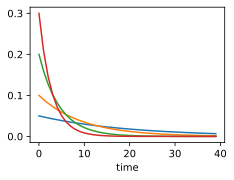

In [1]:
from d2l import torch as d2l
import torch
import math

d2l.set_figsize()
gammas = [0.95, 0.9, 0.8, 0.7]
for gamma in gammas:
    x = torch.arange(40).detach().numpy()
    d2l.plt.plot(x, (1 - gamma) * gamma**x, label=f'gamma = {gamma:.2f}')
d2l.plt.xlabel('time')

### 11.12.2. Lập trình Từ đầu
Như trước đây, chúng ta sử dụng hàm bậc hai  $f(\mathbf{x})=0.1x_1^2+2x_2^2$  để quan sát quỹ đạo của RMSProp. Nhớ lại trong Section 11.11, khi chúng ta sử dụng Adagrad với tốc độ học bằng 0.4, các biến di chuyển rất chậm trong các giai đoạn sau của thuật toán do tốc độ học giảm quá nhanh. Do  $η$  được kiểm soát riêng biệt, nên điều này không xảy ra với RMSProp.

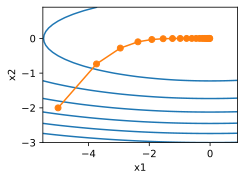

In [2]:
def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma = 0.4, 0.9
d2l.show_trace_2d(f_2d, d2l.train_2d(rmsprop_2d))

Tiếp theo, chúng ta hãy lập trình thuật toán RMSProp để sử dụng trong một mạng nơ-ron sâu. Cách lập trình không quá phức tạp.

In [3]:
def init_rmsprop_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] = gamma * s + (1 - gamma) * torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

Chúng ta khởi tạo tốc độ học ban đầu bằng 0.01 và trọng số  $γ$  bằng 0.9. Nghĩa là,  $s$  là tổng trung bình của  $1/(1−γ)=10$  quan sát bình phương gradient trong quá khứ.

loss: 0.243, 0.015 sec/epoch


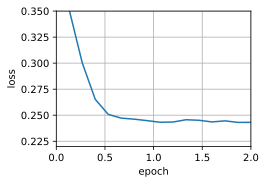

In [4]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(rmsprop, init_rmsprop_states(feature_dim),
               {'lr': 0.01, 'gamma': 0.9}, data_iter, feature_dim);

### 11.12.3. Lập trình Súc tích
Do **RMSProp** là thuật toán khá phổ biến, nó cũng được tích hợp sẵn trong thực thể Trainer. Những gì ta cần phải làm là khởi tạo thuật toán có tên là `rmsprop`, với  $γ$  được gán cho tham số `gamma1`.

loss: 0.243, 0.013 sec/epoch


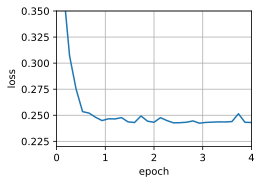

In [5]:
trainer = torch.optim.RMSprop
d2l.train_concise_ch11(trainer, {'lr': 0.01, 'alpha': 0.9},
                       data_iter)

### 11.12.4. Tóm tắt
* Thuật toán RMSProp rất giống với Adagrad ở chỗ cả hai đều sử dụng bình phương của gradient để thay đổi tỉ lệ hệ số.
* RMSProp có điểm chung với phương pháp động lượng là chúng đều sử dụng trung bình rò rỉ. Tuy nhiên, RMSProp sử dụng kỹ thuật này để điều chỉnh tiền điều kiện theo hệ số.
* Trong thực tế, tốc độ học cần được định thời bởi người lập trình.
* Hệ số  $γ$  xác định độ dài thông tin quá khứ được sử dụng khi điều chỉnh tỉ lệ theo từng tọa độ.

### 11.12.5. Bài tập
1. Điều gì sẽ xảy ra nếu ta đặt  $γ=1$ ? Giải thích tại sao?
2. Biến đổi bài toán tối ưu thành cực tiểu hóa  $f(\mathbf{x}) = 0.1 (x_1 + x_2)^2 + 2 (x_1 - x_2)^2$ . Sự hội tụ sẽ diễn ra như thế nào?
3. Hãy thử áp dụng RMSProp cho một bài toán học máy cụ thể, chẳng hạn như huấn luyện trên tập Fashion-MNIST. Hãy thí nghiệm với các tốc độ học khác nhau.
4. Bạn có muốn điều chỉnh  $γ$  khi việc tối ưu đang tiến triển không? Hãy cho biết độ nhạy của RMSProp với việc điều chỉnh này?

## 11.13. Adadelta
**Adadelta** là một biến thể khác của **AdaGrad**. Điểm khác biệt chính là Adadelta giảm mức độ mà tốc độ học sẽ thay đổi với các tọa độ. Hơn nữa, Adadelta thường được biết đến là thuật toán không sử dụng tốc độ học vì nó dựa trên chính lượng thay đổi hiện tại để căn chỉnh lượng thay đổi trong tương lai. Thuật toán Adadelta được đề xuất trong [Zeiler, 2012](https://arxiv.org/abs/1212.5701). Nó cũng khá đơn giản nếu bạn đã biết các thuật toán được thảo luận trước đây.

### 11.13.1. Thuật toán
Nói ngắn gọn, Adadelta sử dụng hai biến trạng thái,  $\mathbf{s}_t$  để lưu trữ trung bình rò rỉ mô-men bậc hai của gradient và  $\Delta\mathbf{x}_t$  để lưu trữ trung bình rò rỉ mô-men bậc hai của lượng thay đổi của các tham số trong mô hình. Lưu ý rằng chúng ta sử dụng các ký hiệu và cách đặt tên nguyên bản của chính tác giả để nhất quán với các nghiên cứu khác và các cách lập trình, chứ không có lý do gì đặc biệt để ký hiệu cùng một tham số trong các thuật toán động lượng, **Adagrad, RMSProp, và Adadelta** bằng các kí hiệu La Mã khác nhau. Tham số suy giảm là  $ρ$ . Chúng ta có được các bước cập nhật rò rỉ như sau:

\begin{split}\begin{aligned}
    \mathbf{s}_t & = \rho \mathbf{s}_{t-1} + (1 - \rho) \mathbf{g}_t^2, \\
    \mathbf{g}_t' & = \sqrt{\frac{\Delta\mathbf{x}_{t-1} + \epsilon}{\mathbf{s}_t + \epsilon}} \odot \mathbf{g}_t, \\
    \mathbf{x}_t  & = \mathbf{x}_{t-1} - \mathbf{g}_t', \\
    \Delta \mathbf{x}_t & = \rho \Delta\mathbf{x}_{t-1} + (1 - \rho) \mathbf{x}_t^2.
\end{aligned}\end{split}
 
Điểm khác biệt so với trước là ta thực hiện các bước cập nhật với gradient  $\mathbf{g}_t'$  được tái tỉ lệ bằng cách lấy căn bậc hai thương của trung bình tốc độ thay đổi bình phương và trung bình mô-men bậc hai của gradient. Việc sử dụng  $\mathbf{g}_t'$  có mục đích đơn thuần là thuận tiện cho việc ký hiệu. Trong thực tế chúng ta có thể lập trình thuật toán này mà không cần phải sử dụng thêm bộ nhớ tạm cho  $\mathbf{g}_t'$ . Như trước đây  $ϵ$  là tham số đảm bảo kết quả xấp xỉ có ý nghĩa, tức tránh trường hợp kích thước bước bằng  $0$  hoặc phương sai là vô hạn. Thông thường ta đặt $\epsilon = 10^{-5}$.

### 11.13.2. Lập trình
Thuật toán Adadelta cần duy trì hai biến trạng thái ứng với hai biến  $\mathbf{s}_t$  và  $\Delta\mathbf{x}_t$ . Do đó ta lập trình như sau.

In [6]:
%matplotlib inline
from d2l import torch as d2l
import torch

def init_adadelta_states(feature_dim):
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    delta_w, delta_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        with torch.no_grad():
            # In-place updates via [:]
            s[:] = rho * s + (1 - rho) * torch.square(p.grad)
            g = (torch.sqrt(delta + eps) / torch.sqrt(s + eps)) * p.grad
            p[:] -= g
            delta[:] = rho * delta + (1 - rho) * g * g
        p.grad.data.zero_()

Việc chọn  $ρ=0.9$  ứng với chu kỳ bán rã bằng 10 cho mỗi lần cập nhật tham số, và thường thì nó là lựa chọn khá tốt. Thuật toán sẽ hoạt động như sau.

loss: 0.244, 0.017 sec/epoch


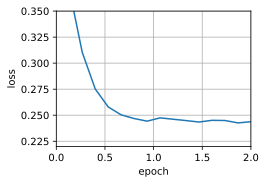

In [7]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adadelta, init_adadelta_states(feature_dim),
               {'rho': 0.9}, data_iter, feature_dim);

Để lập trình súc tích, ta chỉ cần sử dụng thuật toán `adadelta` từ lớp `Trainer`. Nhờ vậy mà ta có thể chạy thuật toán chỉ với một dòng lệnh ngắn gọn.

loss: 0.243, 0.015 sec/epoch


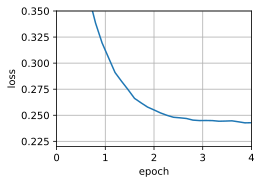

In [8]:
trainer = torch.optim.Adadelta
d2l.train_concise_ch11(trainer, {'rho': 0.9}, data_iter)

### 11.13.3. Tóm tắt
* Adadelta không sử dụng tham số tốc độ học. Thay vào đó, nó sử dụng tốc độ thay đổi của chính bản thân các tham số để điều chỉnh tốc độ học.
* Adadelta cần sử dụng hai biến trạng thái để lưu trữ các mô-men bậc hai của gradient và của lượng thay đổi trong các tham số.
* Adadelta sử dụng trung bình rò rỉ để lưu ước lượng động của các giá trị thống kê cần thiết.

### 11.13.4. Bài tập
1. Điều gì xảy ra khi giá trị của  $ρ$  thay đổi?
2. Hãy lập trình thuật toán trên mà không cần dùng biến $\mathbf{g}_t'$ . Giải thích tại sao đây có thể là một ý tưởng tốt?
3. Adadelta có thực sự không cần tốc độ học? Hãy chỉ ra các bài toán tối ưu mà Adadelta không thể giải.
4. Hãy so sánh Adadelta với Adagrad và RMSprop để thảo luận về sự hội tụ của từng thuật toán.

## 11.14. Adam
Từ các thảo luận dẫn trước, chúng ta đã làm quen với một số kỹ thuật để tối ưu hóa hiệu quả. Hãy cùng tóm tắt chi tiết những kỹ thuật này ở đây:

* Chúng ta thấy rằng SGD trong Section 11.8 hiệu quả hơn hạ gradient khi giải các bài toán tối ưu, ví dụ, nó chịu ít ảnh hưởng xấu gây ra bởi dữ liệu dư thừa.
* Chúng ta thấy rằng minibatch SGD trong Section 11.9 mang lại hiệu quả đáng kể nhờ việc vector hóa, tức xử lý nhiều mẫu quan sát hơn trong một minibatch. Đây là chìa khóa để xử lý dữ liệu song song trên nhiều GPU và nhiều máy tính một cách hiệu quả.
* Phương pháp động lượng trong Section 11.10 bổ sung cơ chế gộp các gradient quá khứ, giúp quá trình hội tụ diễn ra nhanh hơn.
* Adagrad trong Section 11.11 sử dụng phép biến đổi tỉ lệ theo từng tọa độ để tạo ra tiền điều kiện hiệu quả về mặt tính toán.
* RMSprop trong Section 11.12 tách rời phép biến đổi tỉ lệ theo từng tọa độ khỏi phép điều chỉnh tốc độ học.

Adam [Kingma & Ba, 2014](https://arxiv.org/pdf/1412.6980.pdf) kết hợp tất cả các kỹ thuật trên thành một thuật toán học hiệu quả. Như kỳ vọng, đây là một trong những thuật toán tối ưu mạnh mẽ và hiệu quả được sử dụng phổ biến trong học sâu. Tuy nhiên nó cũng có một vài điểm yếu. Cụ thể, [Reddi et al., 2019](https://arxiv.org/abs/1904.09237) đã chỉ ra những trường hợp mà Adam có thể phân kỳ do việc kiểm soát phương sai kém. Trong một nghiên cứu sau đó, [Zaheer et al., 2018](http://www.sanjivk.com/yogi_nips2018.pdf) đã đề xuất **Yogi**, một bản vá nhanh cho Adam để giải quyết các vấn đề này. Chi tiết về bản vá này sẽ được đề cập sau, còn bây giờ hãy xem xét thuật toán **Adam**.

### 11.14.1. Thuật toán
Một trong những thành phần chính của Adam là các trung bình động trọng số mũ (hay còn được gọi là trung bình rò rỉ) để ước lượng cả động lượng và mô-men bậc hai của gradient. Cụ thể, nó sử dụng các biến trạng thái

\begin{split}\begin{aligned}
    \mathbf{v}_t & \leftarrow \beta_1 \mathbf{v}_{t-1} + (1 - \beta_1) \mathbf{g}_t, \\
    \mathbf{s}_t & \leftarrow \beta_2 \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2.
\end{aligned}\end{split}
 
Ở đây  β1  và  β2  là các tham số trọng số không âm. Các lựa chọn phổ biến cho chúng là $β_1=0.9$  và  %β_2=0.999% . Điều này có nghĩa là ước lượng phương sai di chuyển *chậm hơn nhiều* so với số hạng động lượng. Lưu ý rằng nếu ta khởi tạo  $v_0=s_0=0$ , thuật toán sẽ có độ chệch ban đầu đáng kể về các giá trị nhỏ hơn. Vấn đề này có thể được giải quyết bằng cách sử dụng  $\sum_{i=0}^t \beta^i = \frac{1 - \beta^t}{1 - \beta}$  để chuẩn hóa lại các số hạng. Tương tự, các biến trạng thái được chuẩn hóa như sau

<center>$\hat{\mathbf{v}}_t = \frac{\mathbf{v}_t}{1 - \beta_1^t} \text{ and } \hat{\mathbf{s}}_t = \frac{\mathbf{s}_t}{1 - \beta_2^t}$</center>
 
Với các ước lượng thích hợp, bây giờ chúng ta có thể viết ra các phương trình cập nhật. Đầu tiên, chúng ta điều chỉnh lại giá trị gradient, tương tự như ở RMSProp để có được

<center>$\mathbf{g}_t' = \frac{\eta \hat{\mathbf{v}}_t}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}$</center>
 
Không giống như RMSProp, phương trình cập nhật sử dụng động lượng  $v^t$  thay vì gradient. Hơn nữa, có một sự khác biệt nhỏ ở đây: phép chuyển đổi được thực hiện bằng cách sử dụng  $\frac{1}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}$  thay vì  $\frac{1}{\sqrt{\hat{\mathbf{s}}_t + \epsilon}}$. Trong thực tế, cách đầu tiên hoạt động tốt hơn một chút, dẫn đến sự khác biệt này so với RMSProp. Thông thường, ta chọn  $ϵ=10^{−6}$  để cân bằng giữa tính ổn định số học và độ tin cậy.

Bây giờ chúng ta sẽ tổng hợp lại tất cả các điều trên để tính toán bước cập nhật. Có thể bạn sẽ thấy hơi tụt hứng một chút vì thực ra nó khá đơn giản

<center>$\mathbf{x}_t \leftarrow \mathbf{x}_{t-1} - \mathbf{g}_t'$</center>
 
Khi xem xét thiết kế của Adam, ta thấy rõ nguồn cảm hứng của thuật toán. Động lượng và khoảng giá trị được thể hiện rõ ràng trong các biến trạng thái. Định nghĩa khá kì lạ của chúng đòi hỏi ta phải giảm độ chệch của các số hạng (có thể được thực hiện bằng cách tinh chỉnh một chút phép khởi tạo và điều kiện cập nhật). Thứ hai, việc kết hợp của cả hai số hạng trên khá đơn giản, dựa trên RMSProp. Cuối cùng, tốc độ học tường minh  $η$  cho phép ta kiểm soát độ dài bước cập nhật để giải quyết các vấn đề về hội tụ.

### 11.14.2. Lập trình
Lập trình Adam từ đầu không quá khó khăn. Để thuận tiện, chúng ta lưu trữ biến đếm bước thời gian  $t$  trong từ điển `hyperparams`. Ngoài điều đó ra, mọi thứ khác khá đơn giản.

In [9]:
%matplotlib inline
from d2l import torch as d2l
import torch

def init_adam_states(feature_dim):
    v_w, v_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = beta2 * s + (1 - beta2) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

Chúng ta đã sẵn sàng sử dụng Adam để huấn luyện mô hình. Chúng ta sử dụng tốc độ học  $η=0.01$ .

loss: 0.245, 0.017 sec/epoch


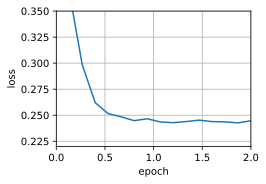

In [10]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adam, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);

Cách lập trình súc tích hơn là gọi trực tiếp `adam` được cung cấp sẵn trong thư viện tối ưu `trainer` của Gluon. Do đó ta chỉ cần truyền các tham số cấu hình để lập trình trong Gluon.

loss: 0.244, 0.015 sec/epoch


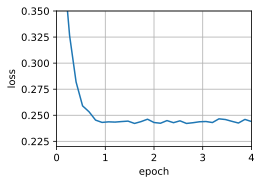

In [11]:
trainer = torch.optim.Adam
d2l.train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

### 11.14.3. Yogi
Một trong những vấn đề của Adam là nó có thể không hội tụ ngay cả trong các điều kiện lồi khi ước lượng mô-men bậc hai trong  st  tăng đột biến. [Zaheer et al., 2018] đề xuất phiên bản cải thiện của bước cập nhật (và khởi tạo)  $\mathbf{s}_t$  để giải quyết vấn đề này. Để hiểu rõ hơn, chúng ta hãy viết lại bước cập nhật Adam như sau:

<center>$\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) \left(\mathbf{g}_t^2 - \mathbf{s}_{t-1}\right)$</center>
 
Khi  $\mathbf{g}_t^2$  có phương sai lớn hay các cập nhật trở nên thưa,  $\mathbf{s}_t$  sẽ có thể nhanh chóng quên mất các giá trị quá khứ. Một cách giải quyết vấn đề trên đó là thay  $\mathbf{g}_t^2 - \mathbf{s}_{t-1}$  bằng  $\mathbf{g}_t^2 \odot \mathop{\mathrm{sgn}}(\mathbf{g}_t^2 - \mathbf{s}_{t-1})$ . Bây giờ, độ lớn của cập nhật không còn phụ thuộc vào giá trị độ lệch. Từ đó ta có bước cập nhật **Yogi** sau:

<center>$\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2 \odot \mathop{\mathrm{sgn}}(\mathbf{g}_t^2 - \mathbf{s}_{t-1})$</center>
 
Hơn nữa, các tác giả khuyên nên khởi tạo động lượng trên một batch ban đầu có kích thước lớn hơn thay vì ước lượng ban đầu theo điểm. Chúng ta không đi sâu vào điểm này, vì quá trình hội tụ vẫn diễn ra khá tốt ngay cả khi không áp dụng chúng.

loss: 0.244, 0.017 sec/epoch


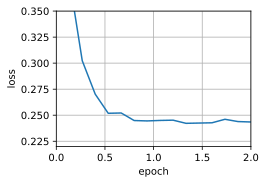

In [12]:
def yogi(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-3
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = s + (1 - beta2) * torch.sign(
                torch.square(p.grad) - s) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(yogi, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);

### 11.14.4. Tóm tắt
* Adam kết hợp các kỹ thuật của nhiều thuật toán tối ưu thành một quy tắc cập nhật khá mạnh mẽ.
* Dựa trên RMSProp, Adam cũng sử dụng trung bình động trọng số mũ cho gradient ngẫu nhiên theo minibatch.
* Adam sử dụng phép hiệu chỉnh độ chệch (**bias correction**) để điều chỉnh cho trường hợp khởi động chậm khi ước lượng động lượng và mô-men bậc hai.
* Đối với gradient có phương sai đáng kể, chúng ta có thể gặp phải những vấn đề liên quan tới hội tụ. Những vấn đề này có thể được khắc phục bằng cách sử dụng các minibatch có kích thước lớn hơn hoặc bằng cách chuyển sang sử dụng ước lượng được cải tiến cho $\mathbf{s}_t$ . Yogi là một trong nhưng giải pháp như vậy.

### 11.14.5. Bài tập
1. Hãy điều chỉnh tốc độ học, quan sát và phân tích kết quả thực nghiệm.
2. Bạn có thể viết lại các phương trình cập nhật cho động lượng và mô-men bậc hai mà không cần thực hiện phép hiệu chỉnh độ chệch (**bias correction**) không?
3. Tại sao ta cần phải giảm tốc độ học  $η$  khi quá trình hội tụ diễn ra?
4. Hãy xây dựng một trường hợp mà thuật toán Adam phân kỳ nhưng Yogi lại hội tụ?